Author: Bruno Kiyoshi (https://www.linkedin.com/in/bkiyoshi/)

---

# Predictive Maintenance of Truck APS System
_Assessing truck air system's need for repair_

This project uses the "Air pressure system failures in Scania trucks" dataset (available at https://www.kaggle.com/datasets/uciml/aps-failure-at-scania-trucks-data-set).

The dataset contains data collected from heavy Scania trucks in everyday usage. The system in focus is the air pressure system (APS) which generates pressurised air that are utilized in various functions in a truck, such as braking and gear changes. The datasets consists of data collected from 6000 trucks, where the majority is negative class (no failures). The data is collected from a range of heavy Scania trucks in everyday usage.

For privacy purposes, the column names have been anonymized. The data consists of both single numerical counters and histograms consisting of bins with different conditions. The positive class in the dataset consists of component failures for a specific component of the APS system. The negative class consists of trucks with failures for components not related to the APS. The data is imbalanced, as there are far more negative samples than positive samples.

## Problem Statement

We assign fictitious cost of:
|Confusion Matrix Element| Cost |Description|
|------------------------|------|-----------|
|False positive          | $15  |Cost if a truck is sent to the shop without need |
|False negative          | $450 |Total costs of a truck breaking during a shipment|
|True positive           | $30  |Cost for repairing a truck that would actually fail|
|True negative           | $0   |Cost for a truck with no failure|

The aim is to create a model that minimizes the total cost of the company.


## Code

### 0. Loading libraries

In [1]:
# General use
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from xgboost import plot_importance as plot_importance_xgb
from lightgbm import plot_importance as plot_importance_lgbm

# Machine learning utilities
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, make_scorer, roc_auc_score, average_precision_score
from sklearn.model_selection import GridSearchCV, cross_validate, RepeatedStratifiedKFold
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from scipy import stats

# Machine learning models
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# General utilities
from functools import wraps
import datetime as dt
import os


pd.set_option('display.max_columns', 171)
pd.set_option('display.max_rows', 150)

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


### 1. Initial data exploration

First of all we must get familiarized with our data.

In this first step we will be trying to look at the data from some different perspectives in order to better understand it be able to make decisions on how to handle it.

In [2]:
# Set data path and filenames
data_dir = "data"
prev_file = "air_system_previous_years.csv"
curr_file = "air_system_present_year.csv"
processed_data_dir = "processed_data"

In [3]:
# Read data
df_prev_orig = pd.read_csv(os.path.join(data_dir,prev_file))
df_curr_orig = pd.read_csv(os.path.join(data_dir,curr_file))
dict_df_orig = {"prev":df_prev_orig, "curr":df_curr_orig}

Taking a first look at our data

Previous years:

In [4]:
df_prev_orig

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,ay_007,ay_008,ay_009,az_000,az_001,az_002,az_003,az_004,az_005,az_006,az_007,az_008,az_009,ba_000,ba_001,ba_002,ba_003,ba_004,ba_005,ba_006,ba_007,ba_008,ba_009,bb_000,bc_000,bd_000,be_000,bf_000,bg_000,bh_000,bi_000,bj_000,bk_000,bl_000,bm_000,bn_000,bo_000,bp_000,bq_000,br_000,bs_000,bt_000,bu_000,bv_000,bx_000,by_000,bz_000,ca_000,cb_000,cc_000,cd_000,ce_000,cf_000,cg_000,ch_000,ci_000,cj_000,ck_000,cl_000,cm_000,cn_000,cn_001,cn_002,cn_003,cn_004,cn_005,cn_006,cn_007,cn_008,cn_009,co_000,cp_000,cq_000,cr_000,cs_000,cs_001,cs_002,cs_003,cs_004,cs_005,cs_006,cs_007,cs_008,cs_009,ct_000,cu_000,cv_000,cx_000,cy_000,cz_000,da_000,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,na,2130706438,280,0,0,0,0,0,0,37250,1432864,3664156,1007684,25896,0,2551696,0,0,0,0,0,4933296,3655166,1766008,1132040,0,0,0,0,1012,268,0,0,0,0,0,469014,4239660,703300,755876,0,5374,2108,4114,12348,615248,5526276,2378,4,0,0,2328746,1022304,415432,287230,310246,681504,1118814,3574,0,0,6700214,0,10,108,50,2551696,97518,947550,799478,330760,353400,299160,305200,283680,na,na,na,178540,76698.08,6700214,6700214,6599892,43566,68656,54064,638360,6167850,1209600,246244,2,96,0,5245752,0,916567.68,6,1924,0,0,0,118196,1309472,3247182,1381362,98822,11208,1608,220,240,6700214,na,10476,1226,267998,521832,428776,4015854,895240,26330,118,0,532,734,4122704,51288,0,532572,0,18,5330690,4732,1126,0,0,0,0,0,0,0,0,62282,85908,32790,0,0,202710,37928,14745580,1876644,0,0,0,0,2801180,2445.8,2712,965866,1706908,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,neg,33058,na,0,na,0,0,0,0,0,0,18254,653294,1720800,516724,31642,0,1393352,0,68,0,0,0,2560898,2127150,1084598,338544,0,0,0,0,0,0,0,0,0,0,0,71510,772720,1996924,99560,0,7336,7808,13776,13086,1010074,1873902,14726,6,0,0,1378576,447166,199512,154298,137280,138668,165908,229652,87082,4708,3646660,86,454,364,350,1393352,49028,688314,392208,341420,359780,366560,na,na,na,na,na,6700,33057.51,3646660,3646660,3582034,17733.0,260120,115626,6900,2942850,1209600,0,na,na,na,2291079.36,0,643536.96,0,0,0,0,38,98644,1179502,1286736,336388,36294,5192,56,na,0,3646660,na,6160,796,164860,350066,272956,1837600,301242,9148,22,0,na,na,na,na,na,na,na,na,na,3312,522,0,0,0,0,0,0,0,0,33736,36946,5936,0,0,103330,16254,4510080,868538,0,0,0,0,3477820,2211.76,2334,664504,824154,421400,178064,293306,245416,133654,81140,97576,1500,0,0
2,neg,41040,na,228,100,0,0,0,0,0,0,1648,370592,1883374,292936,12016,0,1234132,0,0,0,0,0,2371990,2173634,300796,153698,0,0,0,0,358,110,0,0,0,0,0,0,870456,239798,1450312,0,1620,1156,1228,34250,1811606,710672,34,0,0,0,790690,672026,332340,254892,189596,135758,103552,81666,46,0,2673338,128,202,576,4,1234132,28804,160176,139730,137160,130640,na,na,na,na,na,na,28000,41040.08,2673338,2673338,2678534,15439.0,7466,22436,248240,2560566,1209600,63328,0,124,0,2322692.16,0,236099.52,0,0,0,0,0,33276,1215280,1102798,196502,10260,2422,28,0,6,2673338,na,3584,500,56362,149726,100326,1744838,488302,16682,246,0,230,292,2180528,29188,22,20346,0,0,2341048,1494,152,0,0,0,0,0,0,0,0,13876,38182,8138,0,0,65772,10534,300240,48028,0,0,0,0,1040120,1018.64,1020,262032,453378,277378,159812,423992,409564,320746,158022,95128,514,0,0
3,neg,12,0,70,66,0,10,0,0,0,318,2212,3232,1872,0,0,0,2668,0,0,0,642,3894,10184,7554,10764,1014,0,0,0,0,60,6,0,0,0,0,0,0,0,2038,5596,0,64,6,6,914,76,2478,2398,1692,0,0,6176,340,304,102,74,406,216,16,0,0,21614,2,12,0,0,2668,184,7632,3090,na,na,na,na,na,na,na,na,10580,12.69,21614,21614,21772,32,50,1994,21400,7710,120960

In [5]:
df_prev_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 171 entries, class to eg_000
dtypes: int64(1), object(170)
memory usage: 78.3+ MB


#### Sanity check
We spend a few lines of code in order to check whether train and test data are compatible, check their datatypes and other small thing for peace of mind.

#### Are there only two labels and no missing values in 'class' column?


Yes, there are only two different classes, "neg" and "pos", and no entries are missing this label.

Also, "neg" (98%) and "pos" (2%) are highly imbalanced (59:1).


prev
neg    59000
pos     1000
Name: class, dtype: int64
curr
neg    15625
pos      375
Name: class, dtype: int64


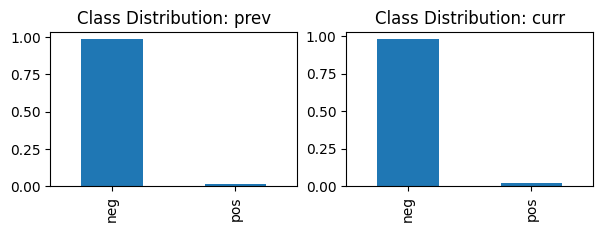

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(7, 2))

for i, key in enumerate(dict_df_orig.keys()):
    print(key)
    print(dict_df_orig[key]["class"].value_counts())

    hist_class = dict_df_orig[key]['class'].value_counts(normalize=True) 
    hist_class.plot(kind='bar', ax=axs[i], title=f"Class Distribution: {key}")

#### Do prev and curr sets have the same columns, and in the same order?
Yes.

In [7]:
def check_same_cols(df_A, df_B):
    return (df_A.columns.values == df_B.columns.values).all()
    
if check_same_cols(df_prev_orig, df_curr_orig): print("Both dataframes have the same columns")

Both dataframes have the same columns


#### What are the datatypes for each column, as parsed by the pd.read_csv method?

Our dataframes have had their columns mostly parsed as "object". 

This means that because of the "na" values, pandas parsed the remaining valid data as strings.

Column aa_000 is the only one that has no missing data, so it was correctly parsed as int64.

Since this is a somewhat controlled dataset, I will assume there are no other "weird" values other than "na". 

All non missing values, excluding the "class" column, are assumed to be numerical strings.

(In less controlled datasets, it would be wise to check whether the dataset is exactly as described by the client.)

**We cannot keep exploring the data in this format. In the next section we convert the data to numerical types so we can keep on analyzing it.**

In [8]:
# Checking column datatypes
def show_col_dtypes(dict_df):
    for df_key in dict_df.keys():
        df = dict_df[df_key]
        dict_dtypes = {}
        for col_name in df.columns:
            col_obj = df[col_name]
            dtype = col_obj.dtype
            dict_dtypes.setdefault(dtype, [])
            dict_dtypes[dtype].append(col_name)

        for dtype_key in dict_dtypes.keys():
            print(f"{df_key} df has {len(dict_dtypes[dtype_key])} columns of type {dtype_key}: {dict_dtypes[dtype_key]}" )

show_col_dtypes(dict_df_orig)

prev df has 170 columns of type object: ['class', 'ab_000', 'ac_000', 'ad_000', 'ae_000', 'af_000', 'ag_000', 'ag_001', 'ag_002', 'ag_003', 'ag_004', 'ag_005', 'ag_006', 'ag_007', 'ag_008', 'ag_009', 'ah_000', 'ai_000', 'aj_000', 'ak_000', 'al_000', 'am_0', 'an_000', 'ao_000', 'ap_000', 'aq_000', 'ar_000', 'as_000', 'at_000', 'au_000', 'av_000', 'ax_000', 'ay_000', 'ay_001', 'ay_002', 'ay_003', 'ay_004', 'ay_005', 'ay_006', 'ay_007', 'ay_008', 'ay_009', 'az_000', 'az_001', 'az_002', 'az_003', 'az_004', 'az_005', 'az_006', 'az_007', 'az_008', 'az_009', 'ba_000', 'ba_001', 'ba_002', 'ba_003', 'ba_004', 'ba_005', 'ba_006', 'ba_007', 'ba_008', 'ba_009', 'bb_000', 'bc_000', 'bd_000', 'be_000', 'bf_000', 'bg_000', 'bh_000', 'bi_000', 'bj_000', 'bk_000', 'bl_000', 'bm_000', 'bn_000', 'bo_000', 'bp_000', 'bq_000', 'br_000', 'bs_000', 'bt_000', 'bu_000', 'bv_000', 'bx_000', 'by_000', 'bz_000', 'ca_000', 'cb_000', 'cc_000', 'cd_000', 'ce_000', 'cf_000', 'cg_000', 'ch_000', 'ci_000', 'cj_000', 'c

### 2. Formating data



This first data pipeline is going to render our data in a form in which we can actually analyze it. 

Steps as dealing with missing data and other ones that can actually modify the data are going to be performed later.

In [9]:
def log_step(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        tic = dt.datetime.now()
        result = func(*args, **kwargs)
        time_taken = str(dt.datetime.now() - tic)
        print(f"just ran step {func.__name__} shape={result.shape} took {time_taken}s")
        return result
    return wrapper

@log_step
def start_pipeline(df):
    return df.copy()

@log_step
def encode_labels(df, encoder, label_col="class"):
    df[label_col] = encoder.transform(df[label_col].values)
    return df

@log_step
def str2num(df):
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    return df

encoder = LabelEncoder()
encoder.fit(df_prev_orig["class"].values) # fit on previous year data

dict_df_formated = {}
for df_key in dict_df_orig.keys():
    print(df_key)
    df = dict_df_orig[df_key]
    dict_df_formated[df_key]=(df.pipe(start_pipeline)
                                 .pipe(encode_labels, encoder=encoder)
                                 .pipe(str2num))

df_prev_formated = dict_df_formated["prev"]
df_curr_formated = dict_df_formated["curr"]

prev
just ran step start_pipeline shape=(60000, 171) took 0:00:00.149817s
just ran step encode_labels shape=(60000, 171) took 0:00:00.327318s
just ran step str2num shape=(60000, 171) took 0:00:29.170168s
curr
just ran step start_pipeline shape=(16000, 171) took 0:00:00.023864s
just ran step encode_labels shape=(16000, 171) took 0:00:00.044390s
just ran step str2num shape=(16000, 171) took 0:00:06.237529s


#### Have all columns been converted to numerical data types?
Yes.

In [10]:
show_col_dtypes(dict_df_formated)

prev df has 1 columns of type int32: ['class']
prev df has 1 columns of type int64: ['aa_000']
prev df has 169 columns of type float64: ['ab_000', 'ac_000', 'ad_000', 'ae_000', 'af_000', 'ag_000', 'ag_001', 'ag_002', 'ag_003', 'ag_004', 'ag_005', 'ag_006', 'ag_007', 'ag_008', 'ag_009', 'ah_000', 'ai_000', 'aj_000', 'ak_000', 'al_000', 'am_0', 'an_000', 'ao_000', 'ap_000', 'aq_000', 'ar_000', 'as_000', 'at_000', 'au_000', 'av_000', 'ax_000', 'ay_000', 'ay_001', 'ay_002', 'ay_003', 'ay_004', 'ay_005', 'ay_006', 'ay_007', 'ay_008', 'ay_009', 'az_000', 'az_001', 'az_002', 'az_003', 'az_004', 'az_005', 'az_006', 'az_007', 'az_008', 'az_009', 'ba_000', 'ba_001', 'ba_002', 'ba_003', 'ba_004', 'ba_005', 'ba_006', 'ba_007', 'ba_008', 'ba_009', 'bb_000', 'bc_000', 'bd_000', 'be_000', 'bf_000', 'bg_000', 'bh_000', 'bi_000', 'bj_000', 'bk_000', 'bl_000', 'bm_000', 'bn_000', 'bo_000', 'bp_000', 'bq_000', 'br_000', 'bs_000', 'bt_000', 'bu_000', 'bv_000', 'bx_000', 'by_000', 'bz_000', 'ca_000', 'cb_0

In [11]:
df_prev_formated

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,ay_007,ay_008,ay_009,az_000,az_001,az_002,az_003,az_004,az_005,az_006,az_007,az_008,az_009,ba_000,ba_001,ba_002,ba_003,ba_004,ba_005,ba_006,ba_007,ba_008,ba_009,bb_000,bc_000,bd_000,be_000,bf_000,bg_000,bh_000,bi_000,bj_000,bk_000,bl_000,bm_000,bn_000,bo_000,bp_000,bq_000,br_000,bs_000,bt_000,bu_000,bv_000,bx_000,by_000,bz_000,ca_000,cb_000,cc_000,cd_000,ce_000,cf_000,cg_000,ch_000,ci_000,cj_000,ck_000,cl_000,cm_000,cn_000,cn_001,cn_002,cn_003,cn_004,cn_005,cn_006,cn_007,cn_008,cn_009,co_000,cp_000,cq_000,cr_000,cs_000,cs_001,cs_002,cs_003,cs_004,cs_005,cs_006,cs_007,cs_008,cs_009,ct_000,cu_000,cv_000,cx_000,cy_000,cz_000,da_000,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,0,76698,NaN,2.130706e+09,280.0,0.0,0.0,0.0,0.0,0.0,0.0,37250.0,1432864.0,3664156.0,1007684.0,25896.0,0.0,2551696.0,0.0,0.0,0.0,0.0,0.0,4933296.0,3655166.0,1766008.0,1132040.0,0.0,0.0,0.0,0.0,1012.0,268.0,0.0,0.0,0.0,0.0,0.0,469014.0,4239660.0,703300.0,755876.0,0.0,5374.0,2108.0,4114.0,12348.0,615248.0,5526276.0,2378.0,4.0,0.0,0.0,2328746.0,1022304.0,415432.0,287230.0,310246.0,681504.0,1118814.0,3574.0,0.0,0.0,6700214.0,0.0,10.0,108.0,50.0,2551696.0,97518.0,947550.0,799478.0,330760.0,353400.0,299160.0,305200.0,283680.0,NaN,NaN,NaN,178540.0,76698.08,6700214.0,6700214.0,6599892.0,43566.0,68656.0,54064.0,638360.0,6167850.0,1209600.0,246244.0,2.0,96.0,0.0,5245752.00,0.00,916567.68,6.0,1924.0,0.0,0.0,0.0,118196.0,1309472.0,3247182.0,1381362.0,98822.0,11208.0,1608.0,220.0,240.0,6700214.0,NaN,10476.0,1226.0,267998.0,521832.0,428776.0,4015854.0,895240.0,26330.0,118.0,0.0,532.0,734.0,4122704.0,51288.0,0.0,532572.0,0.0,18.0,5330690.0,4732.0,1126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,62282.0,85908.0,32790.0,0.0,0.0,202710.0,37928.0,14745580.0,1876644.0,0.0,0.0,0.0,0.0,2801180.0,2445.80,2712.0,965866.0,1706908.0,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,0,33058,NaN,0.000000e+00,NaN,0.0,0.0,0.0,0.0,0.0,0.0,18254.0,653294.0,1720800.0,516724.0,31642.0,0.0,1393352.0,0.0,68.0,0.0,0.0,0.0,2560898.0,2127150.0,1084598.0,338544.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,71510.0,772720.0,1996924.0,99560.0,0.0,7336.0,7808.0,13776.0,13086.0,1010074.0,1873902.0,14726.0,6.0,0.0,0.0,1378576.0,447166.0,199512.0,154298.0,137280.0,138668.0,165908.0,229652.0,87082.0,4708.0,3646660.0,86.0,454.0,364.0,350.0,1393352.0,49028.0,688314.0,392208.0,341420.0,359780.0,366560.0,NaN,NaN,NaN,NaN,NaN,6700.0,33057.51,3646660.0,3646660.0,3582034.0,17733.0,260120.0,115626.0,6900.0,2942850.0,1209600.0,0.0,NaN,NaN,NaN,2291079.36,0.00,643536.96,0.0,0.0,0.0,0.0,38.0,98644.0,1179502.0,1286736.0,336388.0,36294.0,5192.0,56.0,NaN,0.0,3646660.0,NaN,6160.0,796.0,164860.0,350066.0,272956.0,1837600.0,301242.0,9148.0,22.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3312.0,522.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33736.0,36946.0,5936.0,0.0,0.0,103330.0,16254.0,4510080.0,868538.0,0.0,0.0,0.0,0.0,3477820.0,2211.76,2334.0,664504.0,824154.0,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,0,41040,NaN,2.280000e+02,100.0,0.0,0.0,0.0,0.0,0.0,0.0,1648.0,370592.0,1883374.0,292936.0,12016.0,0.0,1234132.0,0.0,0.0,0.0,0.0,0.0,2371990.0,2173634.0,300796.0,153698.0,0.0,0.0,0.0,0.0,358.0,110.0,0.0,0.0,0.0,0.0,0.0,0.0,870456.0,239798.0,1450312.0,0.0,1620.0,1156.0,1228.0,34250.0,1811606.0,710672.0,34.0,0.0,0.0,0.0,790690.0,672026.0,332340.0,254892.0,189596.0,135758.0,103552.0,81666.0,46.0,0.0,2673338.0,128.0,202.0,576.0,4.0,1234132.0,28804.0,160176.0,139730.0,137160.0,130640.0,

In [12]:
df_prev_formated.describe()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,ay_007,ay_008,ay_009,az_000,az_001,az_002,az_003,az_004,az_005,az_006,az_007,az_008,az_009,ba_000,ba_001,ba_002,ba_003,ba_004,ba_005,ba_006,ba_007,ba_008,ba_009,bb_000,bc_000,bd_000,be_000,bf_000,bg_000,bh_000,bi_000,bj_000,bk_000,bl_000,bm_000,bn_000,bo_000,bp_000,bq_000,br_000,bs_000,bt_000,bu_000,bv_000,bx_000,by_000,bz_000,ca_000,cb_000,cc_000,cd_000,ce_000,cf_000,cg_000,ch_000,ci_000,cj_000,ck_000,cl_000,cm_000,cn_000,cn_001,cn_002,cn_003,cn_004,cn_005,cn_006,cn_007,cn_008,cn_009,co_000,cp_000,cq_000,cr_000,cs_000,cs_001,cs_002,cs_003,cs_004,cs_005,cs_006,cs_007,cs_008,cs_009,ct_000,cu_000,cv_000,cx_000,cy_000,cz_000,da_000,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
count,60000.000000,6.000000e+04,13671.000000,5.666500e+04,4.513900e+04,57500.000000,57500.000000,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.935500e+04,5.937100e+04,5.937100e+04,5.560000e+04,5.935800e+04,5.937100e+04,5.935800e+04,5.941100e+04,5.935800e+04,5.941100e+04,57277.000000,5.937100e+04,5.937100e+04,5.937100e+04,57500.000000,57499.000000,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,59329.000000,5.931200e+04,5.931200e+04,5.931200e+04,5.931200e+04,5.931200e+04,5.931200e+04,5.931200e+04,5.931200e+04,5.931200e+04,5.931200e+04,5.935500e+04,57275.000000,57273.000000,57497.000000,57500.000000,5.935800e+04,5.935800e+04,5.941100e+04,5.941100e+04,3.696600e+04,3.272300e+04,2.045100e+04,1.599100e+04,1.366700e+04,1.226000e+04,1.127800e+04,1.073600e+04,5.927400e+04,5.983300e+04,5.930900e+04,5.930900e+04,5.674300e+04,5.952700e+04,5.727700e+04,55644.000000,5.927400e+04,5.674500e+04,59324.0,5.749800e+04,4.513900e+04,45139.000000,45139.000000,5.966200e+04,5.966200e+04,5.966200e+04,50447.000000,50123.000000,5.931300e+04,5.931300e+04,5.931300e+04,5.931300e+04,5.931300e+04,5.931300e+04,5.931300e+04,5.931300e+04,5.931300e+04,5.931300e+04,4.513900e+04,57276.000000,5.930900e+04,13671.000000,59331.000000,59331.000000,5.933100e+04,5.933100e+04,5.933100e+04,5.933100e+04,5.933100e+04,5.933100e+04,5.933100e+04,5.933100e+04,46192.000000,46192.000000,4.619200e+04,4.619200e+04,46192.000000,4.619200e+04,46192.000000,46192.000000,4.619200e+04,57497.000000,57276.000000,5.599200e+04,5.599200e+04,5.599200e+04,5.599400e+04,55993.000000,5.599300e+04,5.599200e+04,5.599100e+04,5.930900e+04,5.727600e+04,57274.000000,5.727400e+04,5.727400e+04,5.727300e+04,57273.000000,5.727400e+04,5.727400e+04,5.727700e+04,5.727600e+04,57277.000000,57277.000000,5.599300e+04,49761.000000,50447.000000,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,57276.000000,57277.000000
mean,0.016667,5.933650e+04,0.713189,3.560143e+08,1.906206e+05,6.819130,11.006817,2.216364e+02,9.757223e+02,8.606015e+03,8.859128e+04,4.370966e+05,1.108374e+06,1.657818e+06,4.993098e+05,3.556989e+04,5.114753e+03,1.809931e+06,9.016965e+03,1.143675e+03,9.794900e+02,5.913048e+04,9.328133e+04,3.461037e+06,3.002440e+06,1.004160e+06,4.424045e+05,0.496918,1.267365e+02,5.072046e+03,2.305804e+02,1117.825913,374.327380,1.221165e+04,1.019012e+04,1.097500e+04,7.225784e+03,1.056600e+04,1.119791e+05,1.078551e+06,1.546032e+06,1.051123e+06,1.162622e+03,7.849608e+03,4.420992e+03,8.066082e+03,8

#### Do any features seem to be normally distributed?
No.

In [13]:
for col in dict_df_formated["curr"].columns:
    k2, p = stats.normaltest(dict_df_formated["curr"][col].values, nan_policy="omit")
    alpha = 1e-3
    
    if p >= alpha:  # null hypothesis: x comes from a normal distribution
        print(f"{col}: p = {p} is normally distributed")
print("-end")

-end


#### Are there negative values in our dataset?

No.

In [14]:
for col in dict_df_formated["curr"].columns:
    if (dict_df_formated["curr"][col].values < 0).any():
        print(f"{col} has negative values")
print("-end")

-end


### 3. Dealing with outliers and missing values


This second pipeline can actually modify data as needed.

E.g. scaling, dropping columns, rows, and filling missing data

#### 3.1 Scaling



Because no columns seem to be normally distributed, we are going to scale our data using MinMax scaling.

Since there are no negative values in the dataset, scaling will be done from 0 to 1.

In [15]:
# min max scaling using scikit learn
min_max_scaler = MinMaxScaler()
min_max_scaler.fit(df_prev_formated) # scaling will be done using test data
dict_df_scaled = {}
for df_key in dict_df_formated.keys():
    print(f'scaling {df_key}')
    df = dict_df_formated[df_key]

    dict_df_scaled[df_key] = pd.DataFrame(min_max_scaler.transform(df), columns=df.columns)
print("-end")

df_prev_scaled = dict_df_scaled["prev"]
df_curr_scaled = dict_df_scaled["curr"]

scaling prev
scaling curr
-end


In [16]:
df_prev_scaled

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,ay_007,ay_008,ay_009,az_000,az_001,az_002,az_003,az_004,az_005,az_006,az_007,az_008,az_009,ba_000,ba_001,ba_002,ba_003,ba_004,ba_005,ba_006,ba_007,ba_008,ba_009,bb_000,bc_000,bd_000,be_000,bf_000,bg_000,bh_000,bi_000,bj_000,bk_000,bl_000,bm_000,bn_000,bo_000,bp_000,bq_000,br_000,bs_000,bt_000,bu_000,bv_000,bx_000,by_000,bz_000,ca_000,cb_000,cc_000,cd_000,ce_000,cf_000,cg_000,ch_000,ci_000,cj_000,ck_000,cl_000,cm_000,cn_000,cn_001,cn_002,cn_003,cn_004,cn_005,cn_006,cn_007,cn_008,cn_009,co_000,cp_000,cq_000,cr_000,cs_000,cs_001,cs_002,cs_003,cs_004,cs_005,cs_006,cs_007,cs_008,cs_009,ct_000,cu_000,cv_000,cx_000,cy_000,cz_000,da_000,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,0.0,0.027925,NaN,9.999998e-01,3.261769e-08,0.0,0.000000,0.0,0.0,0.0,0.000000,1.627842e-04,0.007996,0.038972,0.015907,0.001463,0.000000,0.034368,0.000000,0.000000,0.0,0.000000,0.000000,0.035022,0.029911,0.022660,0.044285,0.000000,0.0,0.000000,0.0,0.001274,0.002297,0.0,0.0,0.0,0.0,0.000000,0.003754,0.033205,0.001436,0.007229,0.0,0.000531,0.000465,2.893584e-04,2.708831e-04,5.000101e-03,0.011813,3.681733e-05,1.021497e-07,0.0,0.0,0.010000,0.008791,0.007444,0.007777,0.012332,0.035479,0.058892,0.000250,0.000000e+00,0.000000e+00,0.034739,0.000000,0.000033,0.000133,0.000979,0.034368,0.030469,0.021086,0.017480,0.252354,0.269627,0.228244,0.232853,0.216434,NaN,NaN,NaN,0.172130,0.027925,0.034739,0.034739,0.035415,0.043479,0.001693,0.446972,0.527780,0.041502,0.0,0.050171,2.329835e-10,0.004486,0.0,0.037208,0.000000,0.016536,0.000046,0.026223,0.0,0.000000,0.000000e+00,1.244439e-03,0.007709,0.027562,0.019164,2.981619e-03,0.001486,4.417780e-05,2.562819e-08,0.000484,0.034739,NaN,0.012483,0.002794,5.815179e-03,0.012301,0.005728,0.010592,0.012140,2.043585e-03,0.000074,0.0,0.000584,0.001000,0.050517,0.001163,0.000000,2.780107e-02,0.0,0.001868,0.044143,0.010630,0.006391,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.021296,0.045829,0.094192,0.000000e+00,0.000000,0.040779,0.057779,0.032041,0.014773,0.000000,0.000000,0.0,0.0,0.002118,0.023069,0.032751,0.012881,0.017378,0.015918,0.013067,7.421784e-03,8.179508e-03,1.073013e-02,0.001321,0.003800,0.000000,0.000000,0.000000
1,0.0,0.012036,NaN,0.000000e+00,NaN,0.0,0.000000,0.0,0.0,0.0,0.000000,7.977081e-05,0.003646,0.018302,0.008157,0.001787,0.000000,0.018766,0.000000,0.000012,0.0,0.000000,0.000000,0.018180,0.017407,0.013917,0.013244,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000572,0.006052,0.004078,0.000952,0.0,0.000725,0.001724,9.689357e-04,2.870729e-04,8.208840e-03,0.004005,2.279950e-04,1.532245e-07,0.0,0.0,0.005920,0.003845,0.003575,0.004178,0.005457,0.007219,0.008733,0.016044,2.785199e-03,1.077188e-04,0.018907,0.000217,0.001481,0.000449,0.006856,0.018766,0.015318,0.015317,0.008575,0.260487,0.274495,0.279667,NaN,NaN,NaN,NaN,NaN,0.006459,0.012036,0.018907,0.018907,0.019221,0.017698,0.006416,0.955934,0.005705,0.019802,0.0,0.000000,NaN,NaN,NaN,0.016250,0.000000,0.011610,0.000000,0.000000,0.0,0.000000,6.494771e-07,1.038584e-03,0.006944,0.010922,0.004667,1.095049e-03,0.000688,1.538530e-06,NaN,0.000000,0.018907,NaN,0.007340,0.001814,3.577230e-03,0.008252,0.003646,0.004847,0.004085,7.100159e-04,0.000014,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.007440,0.002963,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.011535,0.019709,0.017052,0.000000e+00,0.000000,0.020787,0.024761,0.009800,0.006837,0.000000,0.000000,0.0,0.0,0.002630,0.020862,0.028186,0.008862,0.008391,0.005407,0.004716,3.019031e-03,4.272917e-03,4.2285

In [17]:
df_prev_scaled.describe()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,ay_007,ay_008,ay_009,az_000,az_001,az_002,az_003,az_004,az_005,az_006,az_007,az_008,az_009,ba_000,ba_001,ba_002,ba_003,ba_004,ba_005,ba_006,ba_007,ba_008,ba_009,bb_000,bc_000,bd_000,be_000,bf_000,bg_000,bh_000,bi_000,bj_000,bk_000,bl_000,bm_000,bn_000,bo_000,bp_000,bq_000,br_000,bs_000,bt_000,bu_000,bv_000,bx_000,by_000,bz_000,ca_000,cb_000,cc_000,cd_000,ce_000,cf_000,cg_000,ch_000,ci_000,cj_000,ck_000,cl_000,cm_000,cn_000,cn_001,cn_002,cn_003,cn_004,cn_005,cn_006,cn_007,cn_008,cn_009,co_000,cp_000,cq_000,cr_000,cs_000,cs_001,cs_002,cs_003,cs_004,cs_005,cs_006,cs_007,cs_008,cs_009,ct_000,cu_000,cv_000,cx_000,cy_000,cz_000,da_000,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
count,60000.000000,60000.000000,13671.000000,5.666500e+04,4.513900e+04,57500.000000,57500.000000,59329.000000,59329.000000,59329.000000,59329.000000,59329.000000,59329.000000,59329.000000,59329.000000,59329.000000,59329.000000,59355.000000,59371.000000,59371.000000,55600.000000,59358.000000,59371.000000,59358.000000,59411.000000,59358.000000,59411.000000,57277.000000,59371.000000,59371.000000,59371.000000,57500.000000,57499.000000,59329.000000,59329.000000,59329.000000,59329.000000,59329.000000,59329.000000,59329.000000,59329.000000,59329.000000,59329.000000,59329.000000,59329.000000,59329.000000,59329.000000,59329.000000,59329.000000,5.932900e+04,59329.000000,59329.000000,59329.000000,59312.000000,59312.000000,59312.000000,59312.000000,59312.000000,59312.000000,59312.000000,59312.000000,5.931200e+04,59312.000000,59355.000000,57275.000000,57273.000000,57497.000000,57500.000000,59358.000000,59358.000000,59411.000000,59411.000000,36966.000000,32723.000000,20451.000000,15991.000000,13667.000000,12260.000000,11278.000000,10736.000000,59274.000000,59833.000000,59309.000000,59309.000000,56743.000000,59527.000000,5.727700e+04,55644.000000,59274.000000,56745.000000,59324.0,57498.000000,4.513900e+04,45139.000000,45139.000000,59662.000000,59662.000000,59662.000000,50447.000000,50123.000000,59313.000000,59313.000000,59313.000000,59313.000000,59313.000000,59313.000000,59313.000000,59313.000000,59313.000000,5.931300e+04,4.513900e+04,57276.000000,59309.000000,13671.000000,59331.000000,59331.000000,59331.000000,59331.000000,59331.000000,59331.000000,59331.000000,59331.000000,59331.000000,59331.000000,46192.000000,46192.000000,46192.000000,46192.000000,46192.000000,4.619200e+04,46192.000000,46192.000000,46192.000000,57497.000000,57276.000000,55992.000000,55992.000000,55992.000000,55994.000000,55993.000000,55993.000000,55992.000000,55991.000000,59309.000000,57276.000000,57274.000000,57274.000000,57274.000000,57273.000000,57273.000000,57274.000000,57274.000000,57277.000000,57276.000000,57277.000000,57277.000000,55993.000000,49761.000000,50447.000000,59329.000000,59329.000000,59329.000000,59329.000000,59329.000000,59329.000000,59329.000000,5.932900e+04,59329.000000,59329.000000,57276.000000,57277.000000
mean,0.016667,0.021604,0.003496,1.670874e-01,2.220573e-05,0.000324,0.000548,0.000066,0.000237,0.000816,0.001397,0.001910,0.006186,0.017632,0.007882,0.002009,0.000203,0.024377,0.000546,0.000203,0.000094,0.001701,0.001669,0.024570,0.024570,0.012885,0.017307,0.001420,0.000077,0.000488,0.000088,0.001407,0.003209,0.000242,0.000127,0.000385,0.000518,0.000264,0.000896,0.008447,0.003157,0.010052,0.000062,0.000775,0.000976,0.000567,0.001914,0.012003,0.004565,1.577576e-03,0.000444,0.000340,0.000063,0.006010,0.007689,0.007402,0.007419,0.008143,0.009836,0.011087,0.012979,1.147664e-03,0.0

#### 3.2. More analysis

##### How much of the entries have any missing data?

More than ~99% of our entries have at least one missing value.

Dropping incomplete rows would get rid of most of the data, so it's not a good strategy.


In [18]:
df_prev_scaled.dropna(inplace=False)["class"].value_counts() # checking how many rows would be dropped

0.0    515
1.0     76
Name: class, dtype: int64

##### How much of our data is outliers?
Some columns have large number of outliers (>20%).

array([[<AxesSubplot:title={'center':'outlier_pctg'}>]], dtype=object)

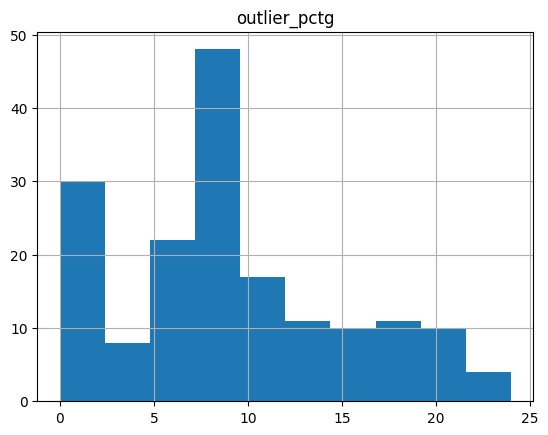

In [19]:
def count_outliers(df):
    outlier_pctg_df = pd.DataFrame(columns=["col_name", "outlier_pctg"])
    for col in df.columns:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - (1.5 * iqr)
        upper_bound = q3 + (1.5 * iqr)
        num_outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)].shape[0]
        outlier_pctg = 100*num_outliers/df[col].count()
        # print(f"{col} has {num_outliers} outliers (percentage={outlier_pctg:.2f}%)")
        outlier_pctg_df = pd.concat([outlier_pctg_df, pd.DataFrame({"col_name":[col], "outlier_pctg":[outlier_pctg]})]).reset_index(drop=True)
    return outlier_pctg_df
outlier_pctg_df = count_outliers(df_prev_scaled)
# plot histogram of outliers
outlier_pctg_df.hist(column="outlier_pctg", bins=10)

# TODO: how many rows in df_prev_scaled have any outliers? 


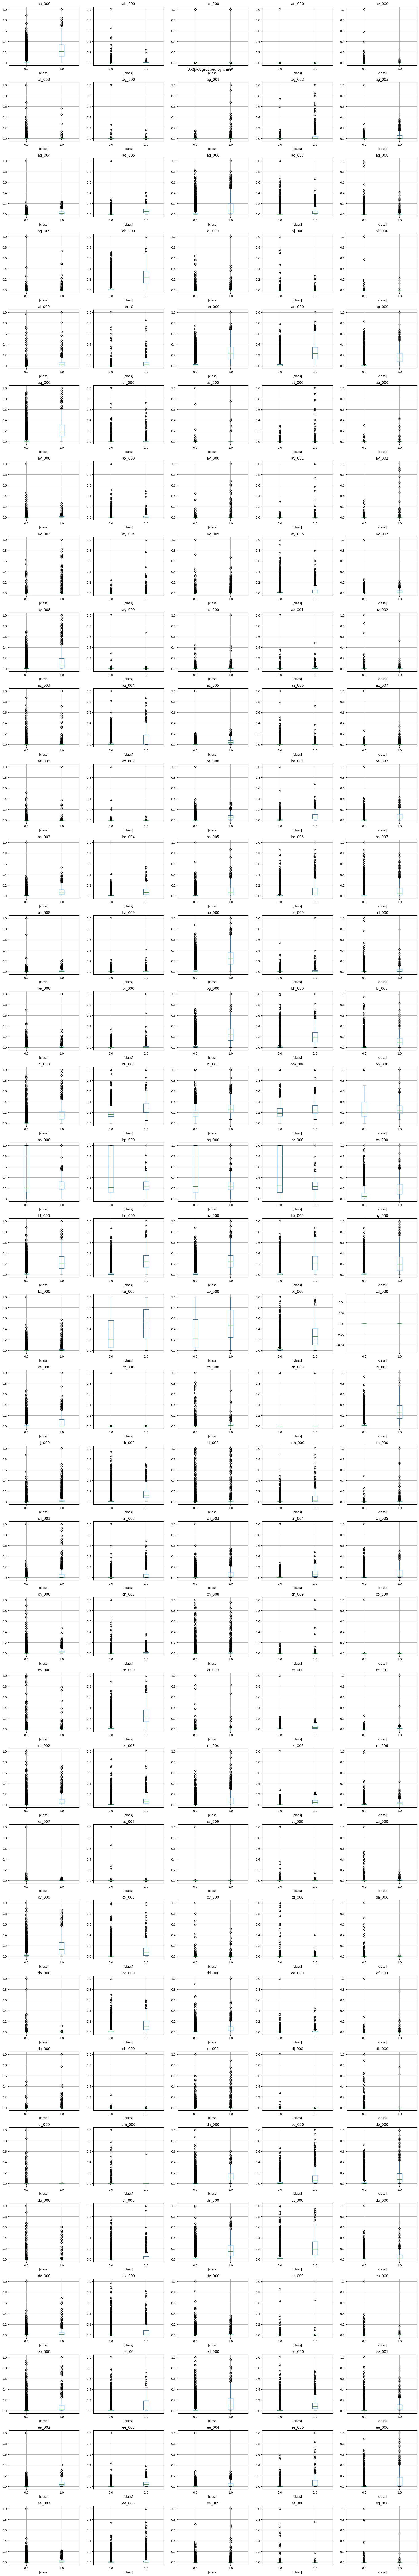

In [20]:
plt.rcParams["figure.autolayout"] = True
ax = df_prev_scaled.boxplot(layout=(50,5), sharex=False, sharey=False, figsize=(20, 180), by="class")
plt.show()

We can see by the figures above that there is quite a significant ammount of outlier data. This might suggest that filling missing data with the mean could result in bias.

##### Are there columns with a lot of missing data?
Yes, columns 'ab_000', 'bm_000', 'bn_000', 'bo_000', 'bp_000', 'bq_000', 'br_000' and 'cr_000' all have more than 50% missing data.

In [21]:
def get_sparse_cols(df, threshold=0.5):
    cols_to_drop = []
    for col in df.columns:
        na_count = df[col].isna().sum()
        na_pctg = na_count / len(df.index)
        
        if na_pctg > threshold:
            txt = f"{col}: ({100*na_pctg:.2f}% na)"
            print(txt, end="; ")
            cols_to_drop.append(col) # columns with > 50% missing values in working dataset are going to be dropped
    print("")
    return cols_to_drop


sparse_cols = get_sparse_cols(df_prev_scaled)
_ = get_sparse_cols(df_curr_scaled)
print(f"columns {sparse_cols} will be dropped")

ab_000: (77.22% na); bm_000: (65.92% na); bn_000: (73.35% na); bo_000: (77.22% na); bp_000: (79.57% na); bq_000: (81.20% na); br_000: (82.11% na); cr_000: (77.22% na); 
ab_000: (77.27% na); bm_000: (65.91% na); bn_000: (73.21% na); bo_000: (77.35% na); bp_000: (79.51% na); bq_000: (81.13% na); br_000: (82.06% na); cr_000: (77.27% na); 
columns ['ab_000', 'bm_000', 'bn_000', 'bo_000', 'bp_000', 'bq_000', 'br_000', 'cr_000'] will be dropped


##### Can columns with a lot of missing data be dropped?

Yes, low correlation between these variables and class indicate that they could be dropped.

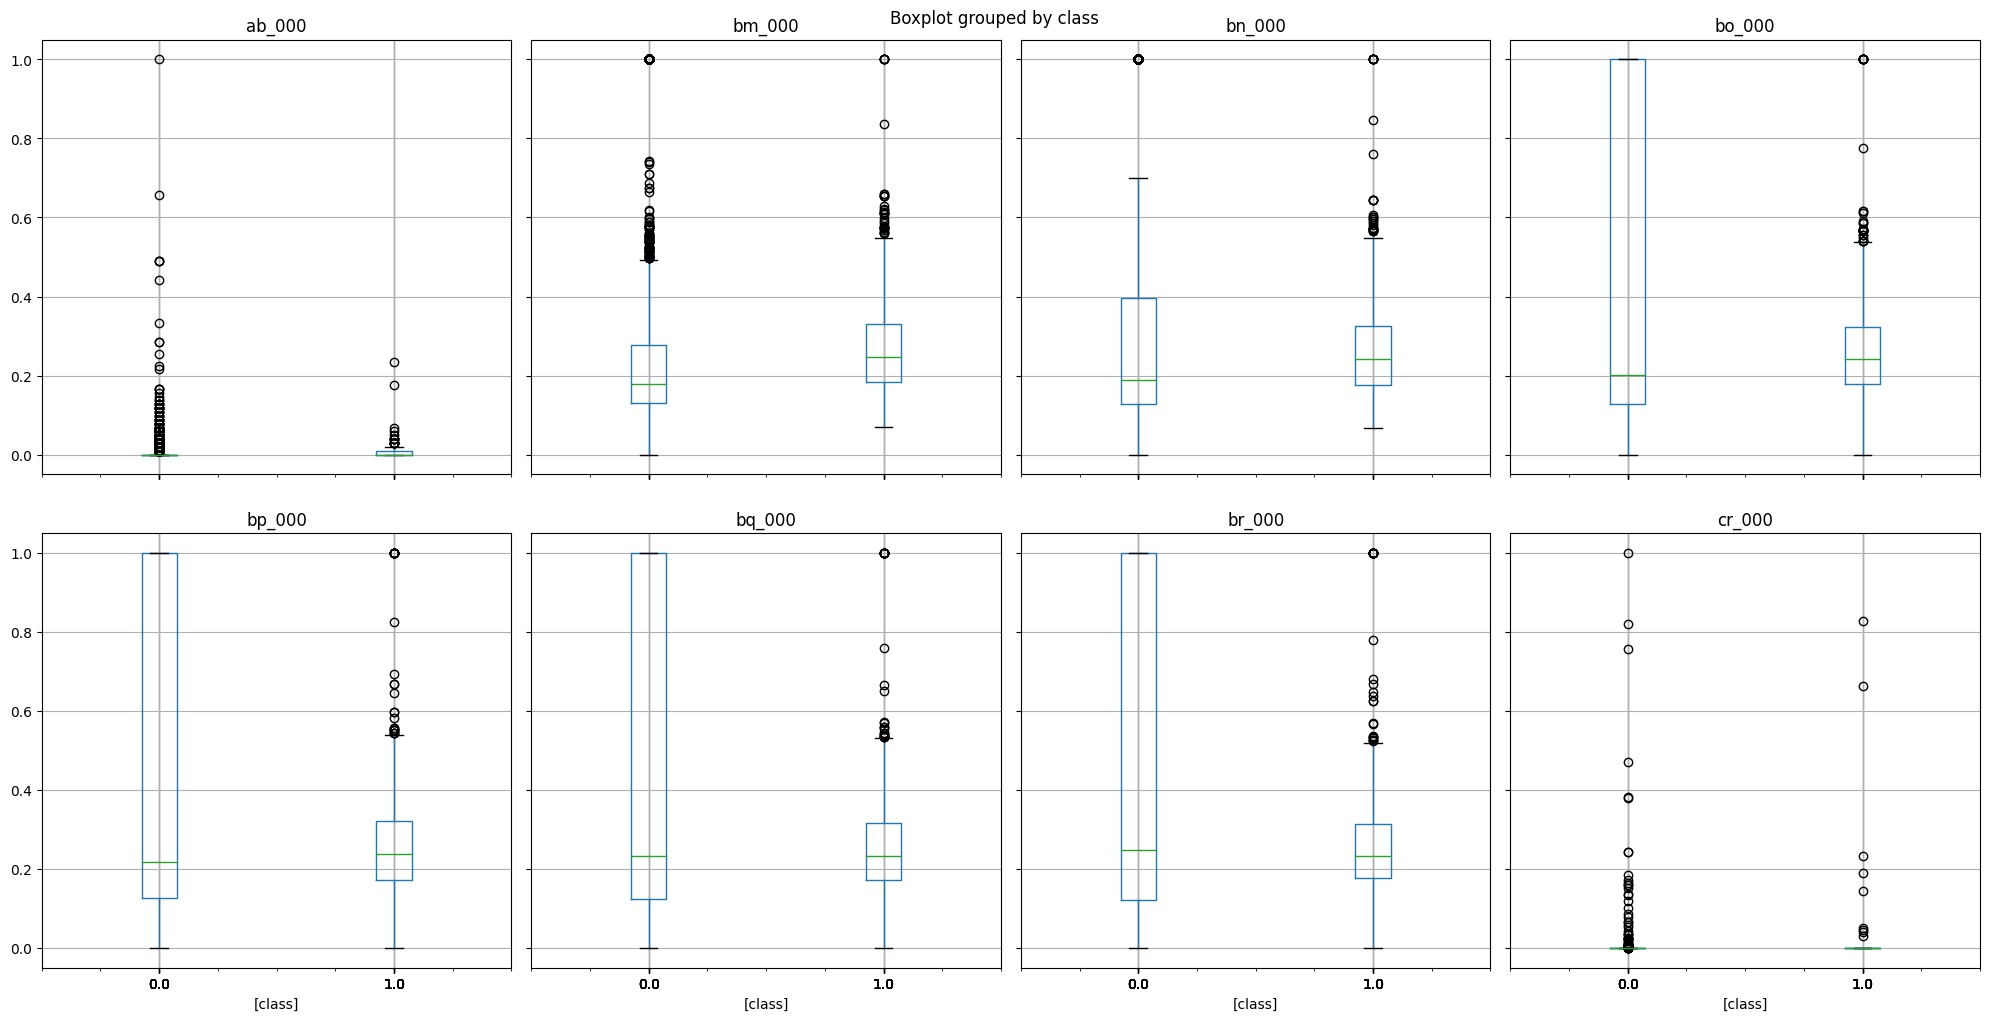

In [22]:
ax = df_prev_scaled[sparse_cols+["class"]].boxplot(layout=(4,4),by="class",figsize=(20, 20), sharex=True, sharey=True)
plt.show()

In [23]:
def plot_histogram_grid(df,col_wrap=4):
    df_long = df.melt(id_vars=["class"], var_name="feature", value_name="value")
    g = sns.FacetGrid(df_long, hue="class", col="feature", col_wrap=col_wrap, sharex=False, sharey=True)
    g.map(plt.hist, "value", bins=50, alpha=0.5, label="class")
    g.add_legend()

In [24]:
df_a = df_prev_scaled[["class"]+sparse_cols][df_prev_scaled["class"]==0].sample(n=1000,random_state=42).reset_index(drop=True)
df_b = df_prev_scaled[["class"]+sparse_cols][df_prev_scaled["class"]==1].reset_index(drop=True)
df_cols2drop_balanced_for_viz = pd.concat([df_a, df_b],axis=0)
print(df_cols2drop_balanced_for_viz["class"].value_counts())
df_cols2drop_balanced_for_viz

# get correlation matrix
corr = df_cols2drop_balanced_for_viz.corr()
corr

0.0    1000
1.0    1000
Name: class, dtype: int64


,class,ab_000,bm_000,bn_000,bo_000,bp_000,bq_000,br_000,cr_000
class,1.000000,0.165647,-0.080492,-0.172485,-0.238686,-0.276195,-0.318620,-0.328767,0.093825
ab_000,0.165647,1.000000,0.077669,0.107016,0.072139,0.066518,0.055929,0.087716,-0.005913
bm_000,-0.080492,0.077669,1.000000,0.928468,0.881127,0.859042,0.829851,0.806985,-0.023636
bn_000,-0.172485,0.107016,0.928468,1.000000,0.942901,0.916872,0.889346,0.863748,-0.048766
bo_000,-0.238686,0.072139,0.881127,0.942901,1.000000,0.959685,0.927914,0.901154,-0.025492
bp_000,-0.276195,0.066518,0.859042,0.916872,0.959685,1.000000,0.962669,0.932932,-0.039297
bq_000,-0.318620,0.055929,0.829851,0.889346,0.927914,0.962669,1.000000,0.961812,-0.040229
br_000,-0.328767,0.087716,0.806985,0.863748,0.901154,0.932932,0.961812,1.000000,-0.034987
cr_000,0.093825,-0.005913,-0.023636,-0.048766,-0.025492,-0.039297,-0.040229,-0.034987,1.000000


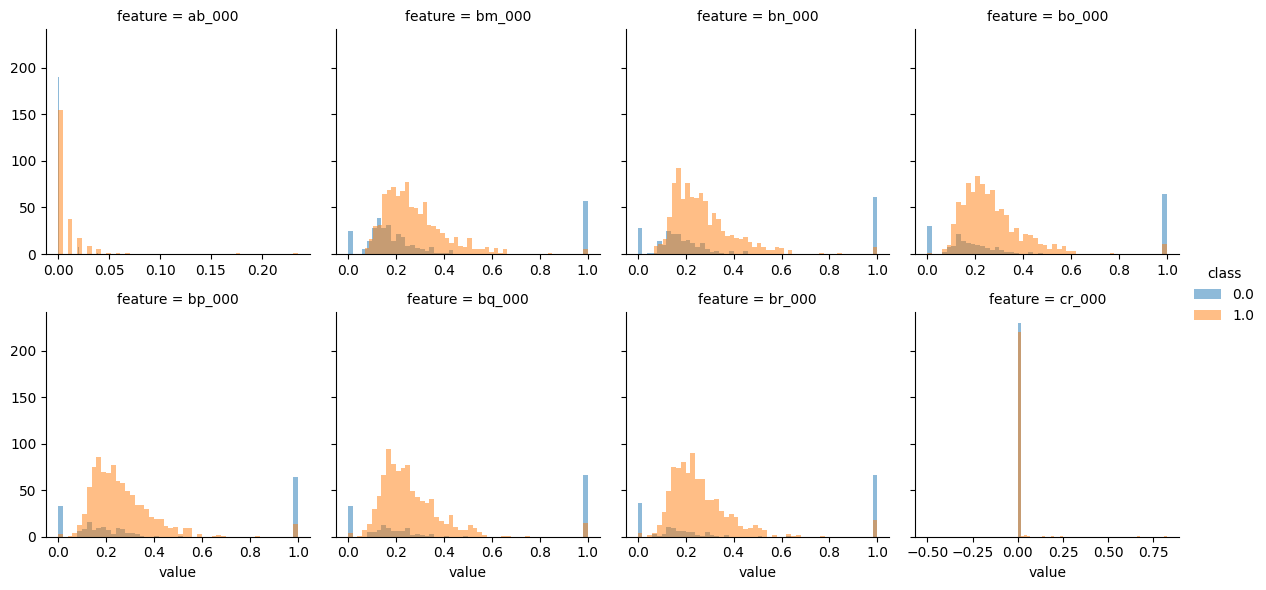

In [25]:
plot_histogram_grid(df_cols2drop_balanced_for_viz)

#### 3.3. Dropping columns and filling nan values

In [26]:
@log_step
def drop_cols(df, col_names=[]):
    return df.drop(axis="columns",columns=col_names)

@log_step
def fillna(df, fill_value="mode"):
    '''
    Note: this is a very naive way of dealing with missing values
    in a real world scenario, we should be using more sophisticated
    methods such as KNN imputation, or using a model to predict the missing values

    Also, note that this method is imputing the TEST SET modes into the test set. It could
    be argued that in production, this value would be unavailable (maybe inference is done
    for single trucks, instead of batches of trucks). In that case, we would need to use
    the training set modes.
    '''     
    for col, col_type in df.dtypes.items():
        if col_type == "float64":
            if fill_value == "mode":
                fill_value = df[col].mode()[0]
            df[col].fillna(fill_value, inplace=True)
    return df

@log_step
def imputing(df,imputer):
    df_x = df.drop(axis="columns",columns=["class"])
    df_y = df["class"]
    df_x = pd.DataFrame(imputer.transform(df_x), columns=df_x.columns)
    df = pd.concat([df_x, df_y], axis=1)
    return df

'''
"The results showed that iterative imputer has higher performances and reliability in missing value data less than 10% 
when kNN has stability in performance for more than 50% of missing value data and iterative imputer gives the various detail 
result number imputation than kNN imputation."
https://www.researchgate.net/publication/355058663
'''

iterative_imputer = IterativeImputer(max_iter=100,n_nearest_features=2, min_value=0,tol=1e-2, random_state=42)
iterative_imputer.fit(df_prev_scaled.drop(axis="columns",columns=["class"]+sparse_cols)) # imputer must be fitted using training data

dict_df_processed = {}
for df_key in dict_df_scaled.keys():
    print(df_key)

    df = dict_df_scaled[df_key]
    dict_df_processed[df_key]=(df.pipe(start_pipeline)
                                 .pipe(drop_cols, col_names=sparse_cols)
                                 .pipe(imputing, imputer=iterative_imputer))

df_prev_processed = dict_df_processed["prev"]
df_curr_processed = dict_df_processed["curr"]

c:\Users\bykiy\anaconda3\envs\ps_bix\lib\site-packages\sklearn\impute\_iterative.py:713: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


prev
just ran step start_pipeline shape=(60000, 171) took 0:00:00.062362s
just ran step drop_cols shape=(60000, 163) took 0:00:00.036872s
just ran step imputing shape=(60000, 163) took 0:00:28.362489s
curr
just ran step start_pipeline shape=(16000, 171) took 0:00:00.049731s
just ran step drop_cols shape=(16000, 163) took 0:00:00.021014s
just ran step imputing shape=(16000, 163) took 0:00:12.399876s


In [27]:
df_prev_processed

,aa_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,ay_007,ay_008,ay_009,az_000,az_001,az_002,az_003,az_004,az_005,az_006,az_007,az_008,az_009,ba_000,ba_001,ba_002,ba_003,ba_004,ba_005,ba_006,ba_007,ba_008,ba_009,bb_000,bc_000,bd_000,be_000,bf_000,bg_000,bh_000,bi_000,bj_000,bk_000,bl_000,bs_000,bt_000,bu_000,bv_000,bx_000,by_000,bz_000,ca_000,cb_000,cc_000,cd_000,ce_000,cf_000,cg_000,ch_000,ci_000,cj_000,ck_000,cl_000,cm_000,cn_000,cn_001,cn_002,cn_003,cn_004,cn_005,cn_006,cn_007,cn_008,cn_009,co_000,cp_000,cq_000,cs_000,cs_001,cs_002,cs_003,cs_004,cs_005,cs_006,cs_007,cs_008,cs_009,ct_000,cu_000,cv_000,cx_000,cy_000,cz_000,da_000,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000,class
0,0.027925,9.999998e-01,3.261769e-08,0.0,0.000000,0.0,0.0,0.0,0.000000,1.627842e-04,0.007996,0.038972,0.015907,0.001463,0.000000,0.034368,0.000000,0.000000,0.0,0.000000,0.000000,0.035022,0.029911,0.022660,0.044285,0.000000,0.0,0.000000,0.0,0.001274,0.002297,0.0,0.0,0.0,0.0,0.000000,0.003754,0.033205,0.001436,0.007229,0.0,0.000531,0.000465,2.893584e-04,2.708831e-04,5.000101e-03,0.011813,3.681733e-05,1.021497e-07,0.0,0.0,0.010000,0.008791,0.007444,0.007777,0.012332,0.035479,0.058892,0.000250,0.000000e+00,0.000000e+00,0.034739,0.000000,0.000033,0.000133,0.000979,0.034368,0.030469,0.021086,0.017480,0.252354,0.269627,0.172130,0.027925,0.034739,0.034739,0.035415,0.043479,0.001693,0.446972,0.527780,0.041502,0.0,0.050171,2.329835e-10,0.004486,0.000000,0.037208,0.000000,0.016536,0.000046,0.026223,0.0,0.000000,0.000000e+00,1.244439e-03,0.007709,0.027562,0.019164,2.981619e-03,0.001486,4.417780e-05,2.562819e-08,0.000484,0.034739,0.012483,0.002794,5.815179e-03,0.012301,0.005728,0.010592,0.012140,2.043585e-03,0.000074,0.0,0.000584,0.001000,0.050517,0.001163,0.000000,2.780107e-02,0.000000,0.001868,0.044143,0.010630,0.006391,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.021296,0.045829,0.094192,0.000000e+00,0.000000,0.040779,0.057779,0.032041,0.014773,0.000000,0.000000,0.0,0.0,0.002118,0.023069,0.032751,0.012881,0.017378,0.015918,0.013067,7.421784e-03,8.179508e-03,1.073013e-02,0.001321,0.003800,0.000000,0.000000,0.000000,0.0
1,0.012036,0.000000e+00,2.179705e-05,0.0,0.000000,0.0,0.0,0.0,0.000000,7.977081e-05,0.003646,0.018302,0.008157,0.001787,0.000000,0.018766,0.000000,0.000012,0.0,0.000000,0.000000,0.018180,0.017407,0.013917,0.013244,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000572,0.006052,0.004078,0.000952,0.0,0.000725,0.001724,9.689357e-04,2.870729e-04,8.208840e-03,0.004005,2.279950e-04,1.532245e-07,0.0,0.0,0.005920,0.003845,0.003575,0.004178,0.005457,0.007219,0.008733,0.016044,2.785199e-03,1.077188e-04,0.018907,0.000217,0.001481,0.000449,0.006856,0.018766,0.015318,0.015317,0.008575,0.260487,0.274495,0.006459,0.012036,0.018907,0.018907,0.019221,0.017698,0.006416,0.955934,0.005705,0.019802,0.0,0.000000,2.175047e-05,0.003628,0.000142,0.016250,0.000000,0.011610,0.000000,0.000000,0.0,0.000000,6.494771e-07,1.038584e-03,0.006944,0.010922,0.004667,1.095049e-03,0.000688,1.538530e-06,2.178471e-05,0.000000,0.018907,0.007340,0.001814,3.577230e-03,0.008252,0.003646,0.004847,0.004085,7.100159e-04,0.000014,0.0,0.001341,0.001719,0.021776,0.003242,0.000340,9.471510e-04,0.000264,0.001402,0.018768,0.007440,0.002963,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.011535,0.019709,0.017052,0.000000e+00,0.000000,0.020787,0.024761,0.009800,0.006837,0.000000,0.000000,0.0,0.0,0.002630,0.020862,0.028186,0.008862,0.008391,0.005407,0.004716,3.019031e-03,4.272917e-03,4.228511e-03,0.000679,0.005064,0.000394,0.000000,0.000

In [28]:
dict_df_processed["prev"].describe()

,aa_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,ay_007,ay_008,ay_009,az_000,az_001,az_002,az_003,az_004,az_005,az_006,az_007,az_008,az_009,ba_000,ba_001,ba_002,ba_003,ba_004,ba_005,ba_006,ba_007,ba_008,ba_009,bb_000,bc_000,bd_000,be_000,bf_000,bg_000,bh_000,bi_000,bj_000,bk_000,bl_000,bs_000,bt_000,bu_000,bv_000,bx_000,by_000,bz_000,ca_000,cb_000,cc_000,cd_000,ce_000,cf_000,cg_000,ch_000,ci_000,cj_000,ck_000,cl_000,cm_000,cn_000,cn_001,cn_002,cn_003,cn_004,cn_005,cn_006,cn_007,cn_008,cn_009,co_000,cp_000,cq_000,cs_000,cs_001,cs_002,cs_003,cs_004,cs_005,cs_006,cs_007,cs_008,cs_009,ct_000,cu_000,cv_000,cx_000,cy_000,cz_000,da_000,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000,class
count,60000.000000,6.000000e+04,6.000000e+04,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,6.000000e+04,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,6.000000e+04,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,6.000000e+04,60000.000000,60000.000000,60000.000000,60000.0,60000.000000,6.000000e+04,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,6.000000e+04,6.000000e+04,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,6.000000e+04,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,6.000000e+04,6.000000e+04,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,6.000000e+04,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000
mean,0.021604,1.654027e-01,2.170785e-05,0.000358,0.000595,0.000065,0.000238,0.000813,0.001396,0.001909,0.006169,0.017585,0.007869,0.002005,0.000203,0.024386,0.000551,0.000204,0.000270,0.001709,0.001675,0.024645,0.024578,0.012926,0.017343,0.001770,0.000077,0.000488,0.000088,0.001525,0.003588,0.000241,0.000126,0.000385,0.000518,0.000263,0.000895,0.008426,0.003147,0.010027,0.000062,0.000773,0.000974,0.000566,0.001911,0.011997,0.004558,1.577084e-03,0.000443,0.000340,0.000063,0.005995,0.007673,0.007395,0.007408,0.008137,0.009816,0.011036,0.012970,1.144548e-03,0.000817,0.023560,0.001841,0.003850,0.002008,0.001843,0.024396,0.018156,0.010968,0.011198,0.216044,0.248224,0.077559,0.021642,0.023470,0.023514,0.022830,0.021953,3.271328e-03,0.3331

### 4. Balancing

In [29]:
def get_X_y(df, label_col="class"):
    X = df.drop(axis="columns", columns=[label_col])
    y = df[label_col]
    return X, y    

def undersample_df(df, label_col="class",n=1000,random_state=42,use_imblearn=False):
    if use_imblearn:
        X, y = get_X_y(df, label_col=label_col)
        rus = RandomUnderSampler(random_state=random_state)
        X_res, y_res = rus.fit_resample(X, y)
        df_res = pd.concat([X_res, y_res], axis=1)
        return df_res
    else: # using imblearn does not allow me to chose the number of samples to keep
        if n > len(df.index):
            raise ValueError(f"Subsample size n = {n} greater than df size {len(df.index)}")
        df_0 = df[df[label_col] == 0].sample(n=n, random_state=random_state)
        df_1 = df[df[label_col] == 1]
        df_balanced = pd.concat([df_0, df_1])
        return df_balanced.reset_index(drop=True)

def oversample_df(df, label_col="class",random_state=42):
    X = df.drop(axis="columns", columns=label_col)
    y = df[label_col]
    sm = SMOTE(random_state=random_state)
    X_res, y_res = sm.fit_resample(X, y)
    df_res = pd.concat([X_res, y_res], axis=1)
    return df_res

def balance_df(df, label_col="class", method="both",n=30000, random_state=42):
    if method == "undersample":
        return undersample_df(df, label_col=label_col,random_state=random_state)
    elif method == "oversample":
        return oversample_df(df, label_col=label_col,random_state=random_state)
    elif method == "both":
        # The combination of SMOTE and under-sampling performs better than plain under-sampling.
        df_undersampled = undersample_df(df, label_col=label_col,n=n,random_state=random_state)
        df_balanced = oversample_df(df_undersampled, label_col=label_col,random_state=random_state)
        return df_balanced.reset_index(drop=True)
    else:
        raise ValueError(f"method {method} not supported")

In [30]:
print(df_prev_processed["class"].value_counts())
df_prev_balanced = balance_df(df_prev_processed, label_col="class")
print(df_prev_balanced["class"].value_counts())
df_prev_balanced

0.0    59000
1.0     1000
Name: class, dtype: int64
0.0    30000
1.0    30000
Name: class, dtype: int64


,aa_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,ay_007,ay_008,ay_009,az_000,az_001,az_002,az_003,az_004,az_005,az_006,az_007,az_008,az_009,ba_000,ba_001,ba_002,ba_003,ba_004,ba_005,ba_006,ba_007,ba_008,ba_009,bb_000,bc_000,bd_000,be_000,bf_000,bg_000,bh_000,bi_000,bj_000,bk_000,bl_000,bs_000,bt_000,bu_000,bv_000,bx_000,by_000,bz_000,ca_000,cb_000,cc_000,cd_000,ce_000,cf_000,cg_000,ch_000,ci_000,cj_000,ck_000,cl_000,cm_000,cn_000,cn_001,cn_002,cn_003,cn_004,cn_005,cn_006,cn_007,cn_008,cn_009,co_000,cp_000,cq_000,cs_000,cs_001,cs_002,cs_003,cs_004,cs_005,cs_006,cs_007,cs_008,cs_009,ct_000,cu_000,cv_000,cx_000,cy_000,cz_000,da_000,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000,class
0,0.012173,0.000000e+00,2.221035e-05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.852766e-05,0.004181,0.015649,0.003694,0.000037,0.000000,0.016228,0.000000,0.000000,0.000000,0.000000,0.000000,0.015152,0.014942,0.008955,0.010563,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000001,8.682904e-03,0.001785,0.004576,0.000000,0.000287,0.000341,0.000294,1.199099e-04,4.631885e-03,0.004013,3.932550e-06,1.532245e-07,0.000000e+00,0.000000,0.005460,0.002622,0.002771,0.003053,0.003508,0.004503,0.007889,0.017163,1.504127e-03,1.496348e-05,0.014686,0.000695,0.000875,0.003092,0.001214,0.016228,0.013746,0.007878,0.007492,0.200153,0.278676,0.064826,0.012173,0.014686,0.014686,0.015114,0.014092,0.002026,0.322415,0.338746,0.016564,0.0,0.000000,0.000022,0.003201,0.000144,0.013201,0.000000,0.010779,0.001768,0.002076,0.000000,0.000000,0.000000,0.002470,0.007379,0.007555,1.034595e-03,2.277957e-04,0.000184,1.648425e-07,2.219810e-05,0.000000,0.014686,0.003217,0.000670,0.002098,0.003309,0.002757,0.004794,0.002629,2.898119e-04,0.000014,0.0,0.000313,0.001387,0.018611,0.005509,0.000281,0.000131,0.000247,0.001568,0.018465,0.002341,0.000329,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.008355,0.018782,0.018488,0.000000,0.000000,0.013486,0.023131,0.005114,0.003023,0.000000,0.000000,0.000000,0.000000,0.024526,0.008947,0.017380,0.008181,0.004170,0.003092,0.002839,0.002258,0.003929,9.738098e-03,0.001284,0.009063,0.002484,0.000000,0.000000,0.0
1,0.000133,0.000000e+00,2.499034e-05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.254276e-07,0.000134,0.000032,0.000000,0.000000,0.000000,0.000139,0.000000,0.000000,0.000000,0.000000,0.000000,0.000214,0.000223,0.000108,0.000043,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.670735e-04,0.000009,0.000011,0.000000,0.000127,0.000004,0.000002,6.581222e-07,5.363799e-07,0.000055,9.289487e-08,0.000000e+00,0.000000e+00,0.000000,0.000061,0.000069,0.000059,0.000021,0.000007,0.000006,0.000010,0.000018,5.117383e-07,0.000000e+00,0.000200,0.000000,0.000150,0.000020,0.000000,0.000139,0.000107,0.000127,0.000059,1.000000,1.000000,0.007963,0.000132,0.000200,0.000200,0.000233,0.000090,0.000011,0.031069,0.031781,0.000182,0.0,0.000000,0.000025,0.002570,0.000152,0.000148,0.000000,0.000089,0.000056,0.000000,0.000000,0.000000,0.000000,0.000209,0.000040,0.000004,6.104294e-07,4.827458e-07,0.000000,0.000000e+00,2.497801e-05,0.000008,0.000200,0.001489,0.000023,0.000014,0.000021,0.000013,0.000016,0.000225,5.339866e-05,0.000001,0.0,0.000000,0.000000,0.014512,0.002684,0.000000,0.000000,0.000189,0.001032,0.010176,0.000162,0.000114,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000070,0.000003,0.000006,0.000000,0.000000,0.000093,0.000174,0.000076,0.000028,0.000000,

In [31]:
df_curr_processed.to_csv(os.path.join(processed_data_dir,"df_curr_processed.csv"), index=False)
df_prev_balanced.to_csv(os.path.join(processed_data_dir,"df_prev_balanced.csv"), index=False)

### 5. Defining functions for model training and evaluation


### 6. Evaluation metrics



Since we want to avoid the False Negatives and maximize the True Positive and True Negative, we'll use two main metrics to compare models:

**Precision**, which is used when raising false alerts is costly and you really want all the positive predictions to be really worth looking at.

**Recall**, which is used when we really care about catching all positive cases even at the cost of false alerts.

Both Precision and Recall are rarely used alone, but usually coupled together. The **Precision-Recall AUC** is a metric that couples both of them.

In [32]:
def calculate_costs(confusion_matrix):
    fp_cost = 15
    fn_cost = 450
    tp_cost = 30
    tn_cost = 0

    tn, fp, fn, tp = confusion_matrix.ravel()
    
    return (fp_cost * fp) + (fn_cost * fn) + (tp_cost * tp) + (tn_cost * tn)

def evaluate_model(y_true, y_pred):
    dict_metrics = {}
    dict_metrics["accuracy"] = accuracy_score(y_true, y_pred)
    dict_metrics["precision"] = precision_score(y_true, y_pred)
    dict_metrics["recall"] = recall_score(y_true, y_pred)
    dict_metrics["f1"] = f1_score(y_true, y_pred)
    dict_metrics["confusion_matrix"] = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = dict_metrics["confusion_matrix"].ravel()
    dict_metrics["tn"] = tn
    dict_metrics["fp"] = fp
    dict_metrics["fn"] = fn
    dict_metrics["tp"] = tp
    costs = calculate_costs(dict_metrics["confusion_matrix"])
    dict_metrics["costs"] = costs
    dict_metrics["specificity"] = tn / (tn + fp)
    dict_metrics["sensitivity"] = tp / (tp + fn)
    dict_metrics["false_positive_rate"] = fp / (fp + tn)	
    dict_metrics["false_negative_rate"] = fn / (fn + tp)
    dict_metrics["roc_auc"] = roc_auc_score(y_true, y_pred)
    dict_metrics["pr_auc"] = average_precision_score(y_true, y_pred)
    
    return dict_metrics

def maintenance_costs_loss_func(y_true, y_pred): # wrapper so we have the right function signature for make_scorer
    return calculate_costs(confusion_matrix(y_true, y_pred))

maintenance_cost_scorer = make_scorer(maintenance_costs_loss_func, greater_is_better=False)

def scorer_multiple(model,x, y_true):
    scores = {"accuracy": accuracy_score(y_true, model.predict(x)),
              "precision": precision_score(y_true, model.predict(x)),
              "recall": recall_score(y_true, model.predict(x)),
              "f1": f1_score(y_true, model.predict(x)),
              "roc_auc_score": roc_auc_score(y_true, model.predict(x)), # should it be predict_proba(x) ?
              "average_precision_score": average_precision_score(y_true, model.predict(x)), # should it be predict_proba(x) ?
              "maintenance_cost": maintenance_costs_loss_func(y_true, model.predict(x))}
    return scores

def print_cv_scores(score_dict):
    for key, value in score_dict.items():
      print(f'Mean {key}: {np.mean(value):.3f} ({np.std(value):.3f})')

def cross_validate_models(models, X, y, n_splits=4, n_repeats=1 ,scoring=["accuracy", "precision", "recall", "f1", "roc_auc", "prc_auc"], verbose=0):
    cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=42)
    scores = {}
    
    for model_name, model in models.items():
        tic = dt.datetime.now()

        print(f"Cross-validating model: {model_name} ({tic})")
        score_dict = cross_validate(model, X, y, cv=cv, scoring=scoring, verbose=verbose)
        print_cv_scores(score_dict)
        scores[model_name] = score_dict
        time_taken = str(dt.datetime.now() - tic)
        print(f"time:{time_taken}")
    return scores

In [33]:
def train_models(models, X, y):
    
    for model_name, model in models.items():
        tic = dt.datetime.now()

        print(f"Training model: {model_name} ({tic})")
        model.fit(X, y)
        time_taken = str(dt.datetime.now() - tic)
        print(f"time:{time_taken}")
    return models


In [34]:
def evaluate_models(models, X, y):
    scores = {}
    for model_name, model in models.items():
        tic = dt.datetime.now()

        print(f"Evaluating model: {model_name} ({tic})")
        y_pred = model.predict(X)
        scores[model_name] = evaluate_model(y, y_pred)

        # calculate maintenance spendings for this model from confusion matrix
        confusion_matrix = scores[model_name]["confusion_matrix"]
        costs = calculate_costs(confusion_matrix)
        scores[model_name]["costs"] = costs

        time_taken = str(dt.datetime.now() - tic)
        for key, value in scores[model_name].items():
            print(f"{key}={value}",end="; ")
        print(f"time:{time_taken}")
    return scores

### 7. Defining models to be tried

#### 7.1 Reading processed data from disk (if want to run from the cell above on).

In [35]:
if False:
    df_prev_balanced = pd.read_csv(os.path.join(processed_data_dir,"df_prev_balanced.csv"))
    df_curr_processed = pd.read_csv(os.path.join(processed_data_dir,"df_curr_processed.csv"))

#### 7.2 Defining base models

In [36]:
lgbm = LGBMClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
lr = LogisticRegression(random_state=42, n_jobs=-1)
# knn = KNeighborsClassifier(n_jobs=-1) # takes too long
dtc = DecisionTreeClassifier(random_state=42)
dummy = DummyClassifier(random_state=42)
nb = GaussianNB()
xgb = XGBClassifier(random_state=42, n_jobs=-1)

base_models = {"dummy": dummy,
                "xgb": xgb,
                "lgbm": lgbm,
                "rf": rf,
                "lr": lr,
                # "knn": knn, 
                "dtc": dtc,
                "nb": nb
                }



### 8. Trying different models and sets of features

#### 8.1 Models using all features

In [37]:
models = base_models.copy()
train_cols = df_prev_balanced.columns.drop("class")
train_x = df_prev_balanced[train_cols]
train_y = df_prev_balanced["class"]
train_x.head()

,aa_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,ay_007,ay_008,ay_009,az_000,az_001,az_002,az_003,az_004,az_005,az_006,az_007,az_008,az_009,ba_000,ba_001,ba_002,ba_003,ba_004,ba_005,ba_006,ba_007,ba_008,ba_009,bb_000,bc_000,bd_000,be_000,bf_000,bg_000,bh_000,bi_000,bj_000,bk_000,bl_000,bs_000,bt_000,bu_000,bv_000,bx_000,by_000,bz_000,ca_000,cb_000,cc_000,cd_000,ce_000,cf_000,cg_000,ch_000,ci_000,cj_000,ck_000,cl_000,cm_000,cn_000,cn_001,cn_002,cn_003,cn_004,cn_005,cn_006,cn_007,cn_008,cn_009,co_000,cp_000,cq_000,cs_000,cs_001,cs_002,cs_003,cs_004,cs_005,cs_006,cs_007,cs_008,cs_009,ct_000,cu_000,cv_000,cx_000,cy_000,cz_000,da_000,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,0.012173,0.000000e+00,2.221035e-05,0.0,0.0,0.0,0.0,0.0,0.000000,2.852766e-05,0.004181,0.015649,0.003694,0.000037,0.000000,0.016228,0.000000,0.00000,0.0,0.000000,0.000000,0.015152,0.014942,0.008955,0.010563,0.0,0.0,0.0,0.0,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0,0.000001,0.008683,0.001785,0.004576,0.0,0.000287,0.000341,0.000294,1.199099e-04,4.631885e-03,0.004013,3.932550e-06,1.532245e-07,0.000000,0.0,0.005460,0.002622,0.002771,0.003053,0.003508,0.004503,0.007889,0.017163,1.504127e-03,0.000015,0.014686,0.000695,0.000875,0.003092,0.001214,0.016228,0.013746,0.007878,0.007492,0.200153,0.278676,0.064826,0.012173,0.014686,0.014686,0.015114,0.014092,0.002026,0.322415,0.338746,0.016564,0.0,0.000000,0.000022,0.003201,0.000144,0.013201,0.00000,0.010779,0.001768,0.002076,0.0,0.0,0.000000,0.002470,0.007379,0.007555,1.034595e-03,2.277957e-04,0.000184,1.648425e-07,0.000022,0.000000,0.014686,0.003217,0.000670,0.002098,0.003309,0.002757,0.004794,0.002629,0.000290,0.000014,0.0,0.000313,0.001387,0.018611,0.005509,0.000281,0.000131,0.000247,0.001568,0.018465,0.002341,0.000329,0.0,0.0,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.008355,0.018782,0.018488,0.0,0.0,0.013486,0.023131,0.005114,0.003023,0.0,0.000000,0.0,0.0,0.024526,0.008947,0.017380,0.008181,0.004170,0.003092,0.002839,0.002258,0.003929,9.738098e-03,0.001284,0.009063,0.002484,0.0,0.0
1,0.000133,0.000000e+00,2.499034e-05,0.0,0.0,0.0,0.0,0.0,0.000000,7.254276e-07,0.000134,0.000032,0.000000,0.000000,0.000000,0.000139,0.000000,0.00000,0.0,0.000000,0.000000,0.000214,0.000223,0.000108,0.000043,0.0,0.0,0.0,0.0,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000167,0.000009,0.000011,0.0,0.000127,0.000004,0.000002,6.581222e-07,5.363799e-07,0.000055,9.289487e-08,0.000000e+00,0.000000,0.0,0.000061,0.000069,0.000059,0.000021,0.000007,0.000006,0.000010,0.000018,5.117383e-07,0.000000,0.000200,0.000000,0.000150,0.000020,0.000000,0.000139,0.000107,0.000127,0.000059,1.000000,1.000000,0.007963,0.000132,0.000200,0.000200,0.000233,0.000090,0.000011,0.031069,0.031781,0.000182,0.0,0.000000,0.000025,0.002570,0.000152,0.000148,0.00000,0.000089,0.000056,0.000000,0.0,0.0,0.000000,0.000209,0.000040,0.000004,6.104294e-07,4.827458e-07,0.000000,0.000000e+00,0.000025,0.000008,0.000200,0.001489,0.000023,0.000014,0.000021,0.000013,0.000016,0.000225,0.000053,0.000001,0.0,0.000000,0.000000,0.014512,0.002684,0.000000,0.000000,0.000189,0.001032,0.010176,0.000162,0.000114,0.0,0.0,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.000070,0.000003,0.000006,0.0,0.0,0.000093,0.000174,0.000076,0.000028,0.0,0.000000,0.0,0.0,0.000000,0.005347,0.005863,0.000087,0.000045,0.000016,0.000007,0.000004,0.000249,6.327549e-08,0.000000,0.000000,0.000000,0.0,0.0
2,0.014827,0.000000e+00,2.236790e-05,0.0,0.0,0.0,0.0,0.0,0.000000,1.879120e-05,0.003716,0.032315,0.018437,0.005817,0.000010,0.024394,0.000000,0.00000,0.0,0.000000,0.000000,0.028956,0.027639,0.

In [38]:
cv_results = cross_validate_models(models, train_x, train_y, scoring=scorer_multiple)

Cross-validating model: dummy (2023-01-09 22:24:21.780199)


c:\Users\bykiy\anaconda3\envs\ps_bix\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\bykiy\anaconda3\envs\ps_bix\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\bykiy\anaconda3\envs\ps_bix\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\bykiy\anaconda3\envs\ps_bix\lib\site-packages\sklearn\metrics\_classifica

Mean fit_time: 0.064 (0.018)
Mean score_time: 0.086 (0.049)
Mean test_accuracy: 0.500 (0.000)
Mean test_precision: 0.000 (0.000)
Mean test_recall: 0.000 (0.000)
Mean test_f1: 0.000 (0.000)
Mean test_roc_auc_score: 0.500 (0.000)
Mean test_average_precision_score: 0.500 (0.000)
Mean test_maintenance_cost: 3375000.000 (0.000)
time:0:00:00.660471
Cross-validating model: xgb (2023-01-09 22:24:22.440670)
Mean fit_time: 69.302 (0.703)
Mean score_time: 0.946 (0.050)
Mean test_accuracy: 0.996 (0.000)
Mean test_precision: 0.992 (0.000)
Mean test_recall: 0.999 (0.001)
Mean test_f1: 0.996 (0.000)
Mean test_roc_auc_score: 0.996 (0.000)
Mean test_average_precision_score: 0.992 (0.000)
Mean test_maintenance_cost: 230055.000 (2238.295)
time:0:04:41.075819
Cross-validating model: lgbm (2023-01-09 22:29:03.516489)
Mean fit_time: 6.030 (0.660)
Mean score_time: 0.848 (0.110)
Mean test_accuracy: 0.994 (0.000)
Mean test_precision: 0.990 (0.001)
Mean test_recall: 0.998 (0.001)
Mean test_f1: 0.994 (0.000)
Mea

#### 8.2 Models using PCA 

##### Dimensionality reduction

In [39]:

def pca_decompose(df, n_components=2):
    pca = PCA(n_components=n_components, random_state=42)
    x = df.drop(axis="columns", columns=["class"],inplace=False)
    pca.fit(x)
    pca_x = pca.transform(x)
    pca_y = df["class"]
    df_projected = pd.concat([pca_y, pd.DataFrame(pca_x)], axis=1)
    print(f'projected df\'s shape = {df_projected.shape}')
    print(f'explained variance ratio = {pca.explained_variance_ratio_.sum()}')  
    # print(abs( pca.components_ ))
    return df_projected, pca

df_prev_projected, pca = pca_decompose(df_prev_balanced, n_components=50)
df_curr_projected = pd.DataFrame(pca.transform(df_curr_processed.drop(axis="columns", columns=["class"])))

projected df's shape = (60000, 51)
explained variance ratio = 0.9839507547915588


In [40]:
df_prev_projected

,class,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,0.0,-0.599772,0.007181,0.070597,-0.148590,0.002320,0.001860,0.001258,0.004640,0.008345,-0.016580,-0.017129,0.001771,-0.008574,-0.002987,-0.010597,0.002654,-0.006557,0.028987,0.017219,-0.019514,-0.014565,-0.013375,0.000610,-0.004881,0.002548,-0.000809,0.006649,0.007228,0.008172,0.003349,-0.002219,0.000817,-0.004828,-0.003715,-0.001276,0.002144,-0.000621,-0.000043,-0.005778,-0.000995,0.005849,-0.002408,-0.000574,0.001726,-0.002846,-0.000133,-0.004475,0.000084,-0.001566,-0.001019
1,0.0,-0.753389,-0.515183,0.162030,-0.145666,-0.023394,-0.198029,0.924826,-0.175508,-0.246457,0.002549,-0.056576,-0.049628,0.016133,-0.007891,-0.145699,-0.034840,0.021510,0.024686,-0.020608,0.036125,-0.012885,0.048740,0.013521,0.054498,-0.027719,0.011837,-0.054956,-0.086585,0.022205,-0.017449,-0.020916,0.024283,-0.013481,0.003683,0.000160,-0.004921,-0.003924,-0.004092,0.005859,-0.007033,-0.001849,-0.004533,-0.000253,-0.003204,-0.000656,-0.000928,0.003466,-0.004653,-0.002339,-0.000370
2,0.0,-0.587405,-0.072663,0.079018,-0.117399,0.022961,0.023709,-0.047782,0.049030,0.037740,-0.029477,-0.006972,0.035190,0.010849,-0.006596,0.002561,-0.011916,-0.016918,0.006514,0.001591,-0.006242,0.001907,-0.000791,0.002607,0.018755,0.016225,0.001740,-0.006606,0.013726,0.003256,-0.013576,0.009062,0.013104,-0.003878,0.004663,0.001224,-0.007946,0.004470,0.011724,0.002208,-0.005277,-0.001826,-0.001731,-0.007434,-0.002420,-0.005222,-0.000834,-0.000207,0.001601,-0.003031,0.000001
3,0.0,-0.578558,0.273334,0.112000,-0.144283,0.013659,-0.027123,0.026293,0.017763,-0.003192,-0.039110,-0.008226,-0.002799,0.000357,-0.005624,0.016209,0.010241,-0.014010,-0.007777,-0.005423,0.002849,0.002564,0.000625,-0.007253,-0.006921,0.003919,0.000571,0.004678,0.007716,0.001848,0.004718,-0.002446,-0.007727,0.002742,-0.003114,-0.000048,0.005113,-0.004263,-0.004566,-0.002027,0.003428,0.003685,-0.003625,-0.001355,0.002341,0.000638,-0.000001,-0.001332,0.000801,0.001997,-0.000361
4,0.0,0.540111,-0.177186,0.019486,-0.026045,0.051986,0.713502,-0.049319,-0.127453,0.186893,0.180492,-0.135304,0.102394,-0.018849,0.037993,-0.199733,0.074637,-0.155772,0.087602,-0.062564,0.088649,-0.139924,-0.026162,0.038126,0.077904,-0.011204,-0.036521,0.112935,0.013553,0.113624,-0.000801,-0.050384,0.015938,-0.025193,-0.055398,0.008096,0.044058,0.017939,0.015749,-0.070830,-0.007897,0.018740,0.006164,0.043323,0.014160,-0.044361,-0.035676,-0.051454,-0.064212,-0.056606,0.038830
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,1.0,1.102439,0.362128,-0.065359,-0.065316,-0.119717,0.262497,-0.042516,-0.020124,-0.034701,-0.223885,0.189872,-0.207075,0.045637,0.186261,-0.007303,-0.159630,-0.043131,0.030089,-0.053024,0.115632,-0.095852,-0.059375,0.015459,0.058561,-0.008557,0.061118,0.016024,0.005785,0.044581,0.041058,-0.003828,-0.021180,0.009475,0.008399,-0.017285,-0.026886,-0.019705,-0.010739,0.055709,-0.003686,-0.013746,-0.020287,0.021636,0.008088,-0.018728,0.019499,0.038560,0.032347,0.021929,-0.022562
59996,1.0,-0.125690,0.536289,0.227836,-0.031690,0.126644,-0.021763,0.166852,0.004831,0.047708,0.014344,0.001981,-0.022474,0.048603,-0.027390,0.030150,-0.000210,-0.010728,-0.173434,0.005264,0.053329,0.033607,-0.005580,-0.017392,-0.007518,-0.026268,-0.014388,0.054853,0.079061,-0.052849,-0.004777,0.043996,-0.018611,0.069038,-0.045006,0.022307,-0.035243,0.004342,0.018546,-0.022088,0.029643,0.001369,0.005152,0.002915,0.001107,-0.011165,0.000213,0.002649,0.016869,0.008226,-0.011585
59997,1.0,0.667170,-0.076826,-0.267018,-0.203816,-0.150190,0.094928,-0.076985,-0.059600,-0.098102,-0.149889,0.086294,-0.016720,0.038859,-0.012486,-0.001120,0.006541,-0.061920,-0.021398,0.022632,0.044537,-0.007784,-0.025618,0.019453,0.027320,-0.011883,0.001511,0.02

In [41]:
df_prev_projected["class"].value_counts()

0.0    30000
1.0    30000
Name: class, dtype: int64

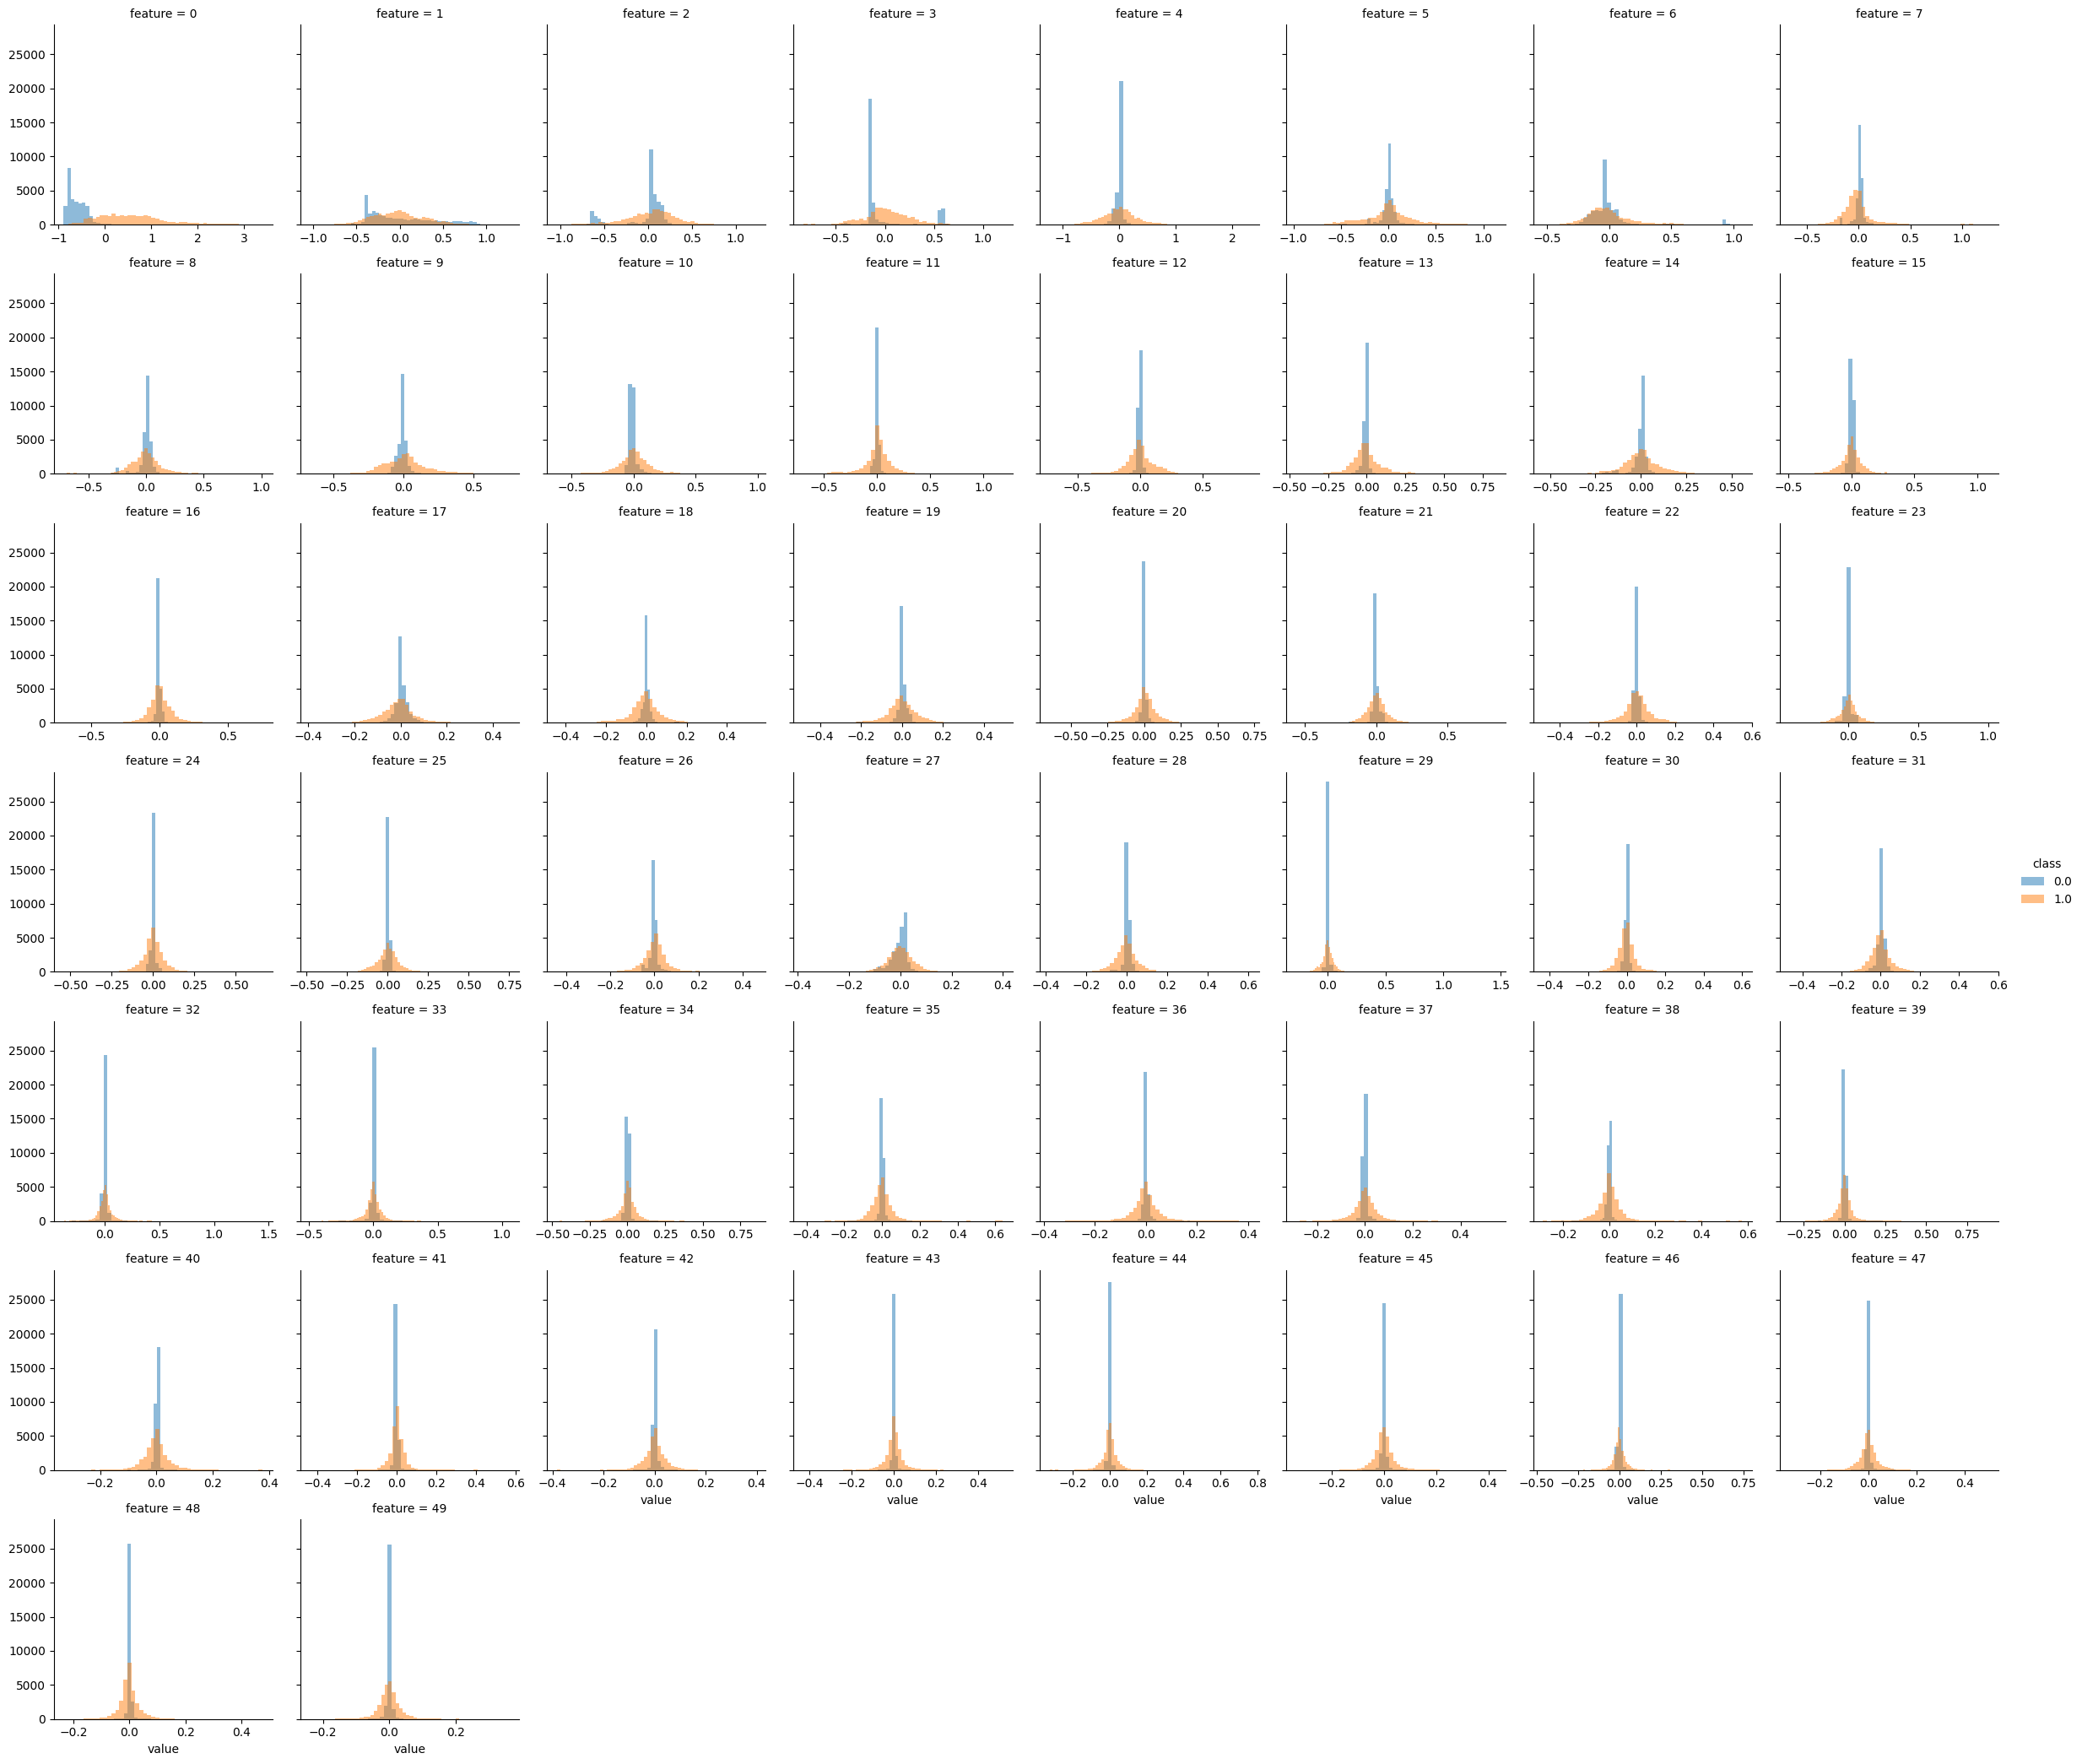

In [42]:
plot_histogram_grid(df_prev_projected, col_wrap=8)

In [43]:
models_pca = base_models.copy()

train_x_pca = df_prev_projected.drop(axis="columns", columns=["class"],inplace=False)
train_x_pca.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,-0.599772,0.007181,0.070597,-0.148590,0.002320,0.001860,0.001258,0.004640,0.008345,-0.016580,-0.017129,0.001771,-0.008574,-0.002987,-0.010597,0.002654,-0.006557,0.028987,0.017219,-0.019514,-0.014565,-0.013375,0.000610,-0.004881,0.002548,-0.000809,0.006649,0.007228,0.008172,0.003349,-0.002219,0.000817,-0.004828,-0.003715,-0.001276,0.002144,-0.000621,-0.000043,-0.005778,-0.000995,0.005849,-0.002408,-0.000574,0.001726,-0.002846,-0.000133,-0.004475,0.000084,-0.001566,-0.001019
1,-0.753389,-0.515183,0.162030,-0.145666,-0.023394,-0.198029,0.924826,-0.175508,-0.246457,0.002549,-0.056576,-0.049628,0.016133,-0.007891,-0.145699,-0.034840,0.021510,0.024686,-0.020608,0.036125,-0.012885,0.048740,0.013521,0.054498,-0.027719,0.011837,-0.054956,-0.086585,0.022205,-0.017449,-0.020916,0.024283,-0.013481,0.003683,0.000160,-0.004921,-0.003924,-0.004092,0.005859,-0.007033,-0.001849,-0.004533,-0.000253,-0.003204,-0.000656,-0.000928,0.003466,-0.004653,-0.002339,-0.000370
2,-0.587405,-0.072663,0.079018,-0.117399,0.022961,0.023709,-0.047782,0.049030,0.037740,-0.029477,-0.006972,0.035190,0.010849,-0.006596,0.002561,-0.011916,-0.016918,0.006514,0.001591,-0.006242,0.001907,-0.000791,0.002607,0.018755,0.016225,0.001740,-0.006606,0.013726,0.003256,-0.013576,0.009062,0.013104,-0.003878,0.004663,0.001224,-0.007946,0.004470,0.011724,0.002208,-0.005277,-0.001826,-0.001731,-0.007434,-0.002420,-0.005222,-0.000834,-0.000207,0.001601,-0.003031,0.000001
3,-0.578558,0.273334,0.112000,-0.144283,0.013659,-0.027123,0.026293,0.017763,-0.003192,-0.039110,-0.008226,-0.002799,0.000357,-0.005624,0.016209,0.010241,-0.014010,-0.007777,-0.005423,0.002849,0.002564,0.000625,-0.007253,-0.006921,0.003919,0.000571,0.004678,0.007716,0.001848,0.004718,-0.002446,-0.007727,0.002742,-0.003114,-0.000048,0.005113,-0.004263,-0.004566,-0.002027,0.003428,0.003685,-0.003625,-0.001355,0.002341,0.000638,-0.000001,-0.001332,0.000801,0.001997,-0.000361
4,0.540111,-0.177186,0.019486,-0.026045,0.051986,0.713502,-0.049319,-0.127453,0.186893,0.180492,-0.135304,0.102394,-0.018849,0.037993,-0.199733,0.074637,-0.155772,0.087602,-0.062564,0.088649,-0.139924,-0.026162,0.038126,0.077904,-0.011204,-0.036521,0.112935,0.013553,0.113624,-0.000801,-0.050384,0.015938,-0.025193,-0.055398,0.008096,0.044058,0.017939,0.015749,-0.070830,-0.007897,0.018740,0.006164,0.043323,0.014160,-0.044361,-0.035676,-0.051454,-0.064212,-0.056606,0.038830


In [44]:
cv_results_pca = cross_validate_models(models_pca,train_x_pca, train_y,scoring=scorer_multiple)

Cross-validating model: dummy (2023-01-09 22:34:15.181417)


c:\Users\bykiy\anaconda3\envs\ps_bix\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\bykiy\anaconda3\envs\ps_bix\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\bykiy\anaconda3\envs\ps_bix\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\bykiy\anaconda3\envs\ps_bix\lib\site-packages\sklearn\metrics\_classifica

Mean fit_time: 0.026 (0.006)
Mean score_time: 0.077 (0.027)
Mean test_accuracy: 0.500 (0.000)
Mean test_precision: 0.000 (0.000)
Mean test_recall: 0.000 (0.000)
Mean test_f1: 0.000 (0.000)
Mean test_roc_auc_score: 0.500 (0.000)
Mean test_average_precision_score: 0.500 (0.000)
Mean test_maintenance_cost: 3375000.000 (0.000)
time:0:00:00.449421
Cross-validating model: xgb (2023-01-09 22:34:15.631838)
Mean fit_time: 34.043 (0.536)
Mean score_time: 0.492 (0.032)
Mean test_accuracy: 0.991 (0.000)
Mean test_precision: 0.985 (0.001)
Mean test_recall: 0.998 (0.001)
Mean test_f1: 0.992 (0.000)
Mean test_roc_auc_score: 0.991 (0.000)
Mean test_average_precision_score: 0.984 (0.001)
Mean test_maintenance_cost: 233801.250 (1832.714)
time:0:02:18.182752
Cross-validating model: lgbm (2023-01-09 22:36:33.814590)
Mean fit_time: 2.499 (0.200)
Mean score_time: 0.706 (0.030)
Mean test_accuracy: 0.986 (0.001)
Mean test_precision: 0.979 (0.002)
Mean test_recall: 0.994 (0.001)
Mean test_f1: 0.987 (0.001)
Mea

#### 8.3 Models using only high correlation features

##### Finding high correlated features

In [45]:
def corr_mtx(df,label_col="class", method='spearman'):
    # corr_mtx = df.drop(label_col,axis=1).corrwith(df[label_col],method=method)
    corr_mtx = df.corrwith(df[label_col],method=method)
    return pd.DataFrame(corr_mtx,columns=["corr"])

In [46]:
corr_mtx = corr_mtx(df_prev_balanced)
corr_mtx["abs"] = corr_mtx.abs()
corr_mtx.sort_values(by="abs",ascending=False,inplace=True)
corr_mtx

c:\Users\bykiy\anaconda3\envs\ps_bix\lib\site-packages\scipy\stats\_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


,corr,abs
class,1.000000,1.000000
ck_000,0.822829,0.822829
ci_000,0.821562,0.821562
aa_000,0.819353,0.819353
bt_000,0.817651,0.817651
...,...,...
ay_006,0.155650,0.155650
ay_005,0.143364,0.143364
db_000,0.102493,0.102493
cs_009,0.079505,0.079505


In [47]:
high_corr_cols = corr_mtx[corr_mtx["abs"]>0.5].index
high_corr_cols.values

array(['class', 'ck_000', 'ci_000', 'aa_000', 'bt_000', 'bj_000',
       'bb_000', 'aq_000', 'ap_000', 'dn_000', 'bu_000', 'cq_000',
       'bv_000', 'bh_000', 'bg_000', 'ah_000', 'an_000', 'ao_000',
       'bi_000', 'cs_002', 'cc_000', 'bx_000', 'am_0', 'cs_004', 'dt_000',
       'dc_000', 'ai_000', 'cn_003', 'cx_000', 'dd_000', 'al_000',
       'az_001', 'ee_000', 'az_002', 'ag_005', 'bc_000', 'ds_000',
       'ag_004', 'az_000', 'ba_002', 'ba_003', 'bd_000', 'cs_003',
       'by_000', 'ba_001', 'ba_000', 'az_005', 'cn_002', 'ba_004',
       'be_000', 'cn_004', 'ee_001', 'ee_002', 'cs_005', 'eb_000',
       'cs_001', 'ba_005', 'de_000', 'ag_003', 'ee_005', 'cg_000',
       'cu_000', 'ee_003', 'ay_008', 'cv_000', 'ee_004', 'ba_008',
       'ee_006', 'ba_006', 'ay_007', 'do_000', 'cs_000', 'ec_00',
       'ba_009', 'dp_000', 'ba_007', 'ar_000', 'cy_000', 'ak_000',
       'ed_000', 'di_000', 'df_000', 'dg_000', 'cn_007', 'cn_001',
       'cl_000', 'bz_000', 'dv_000', 'cn_005', 'ee_007',

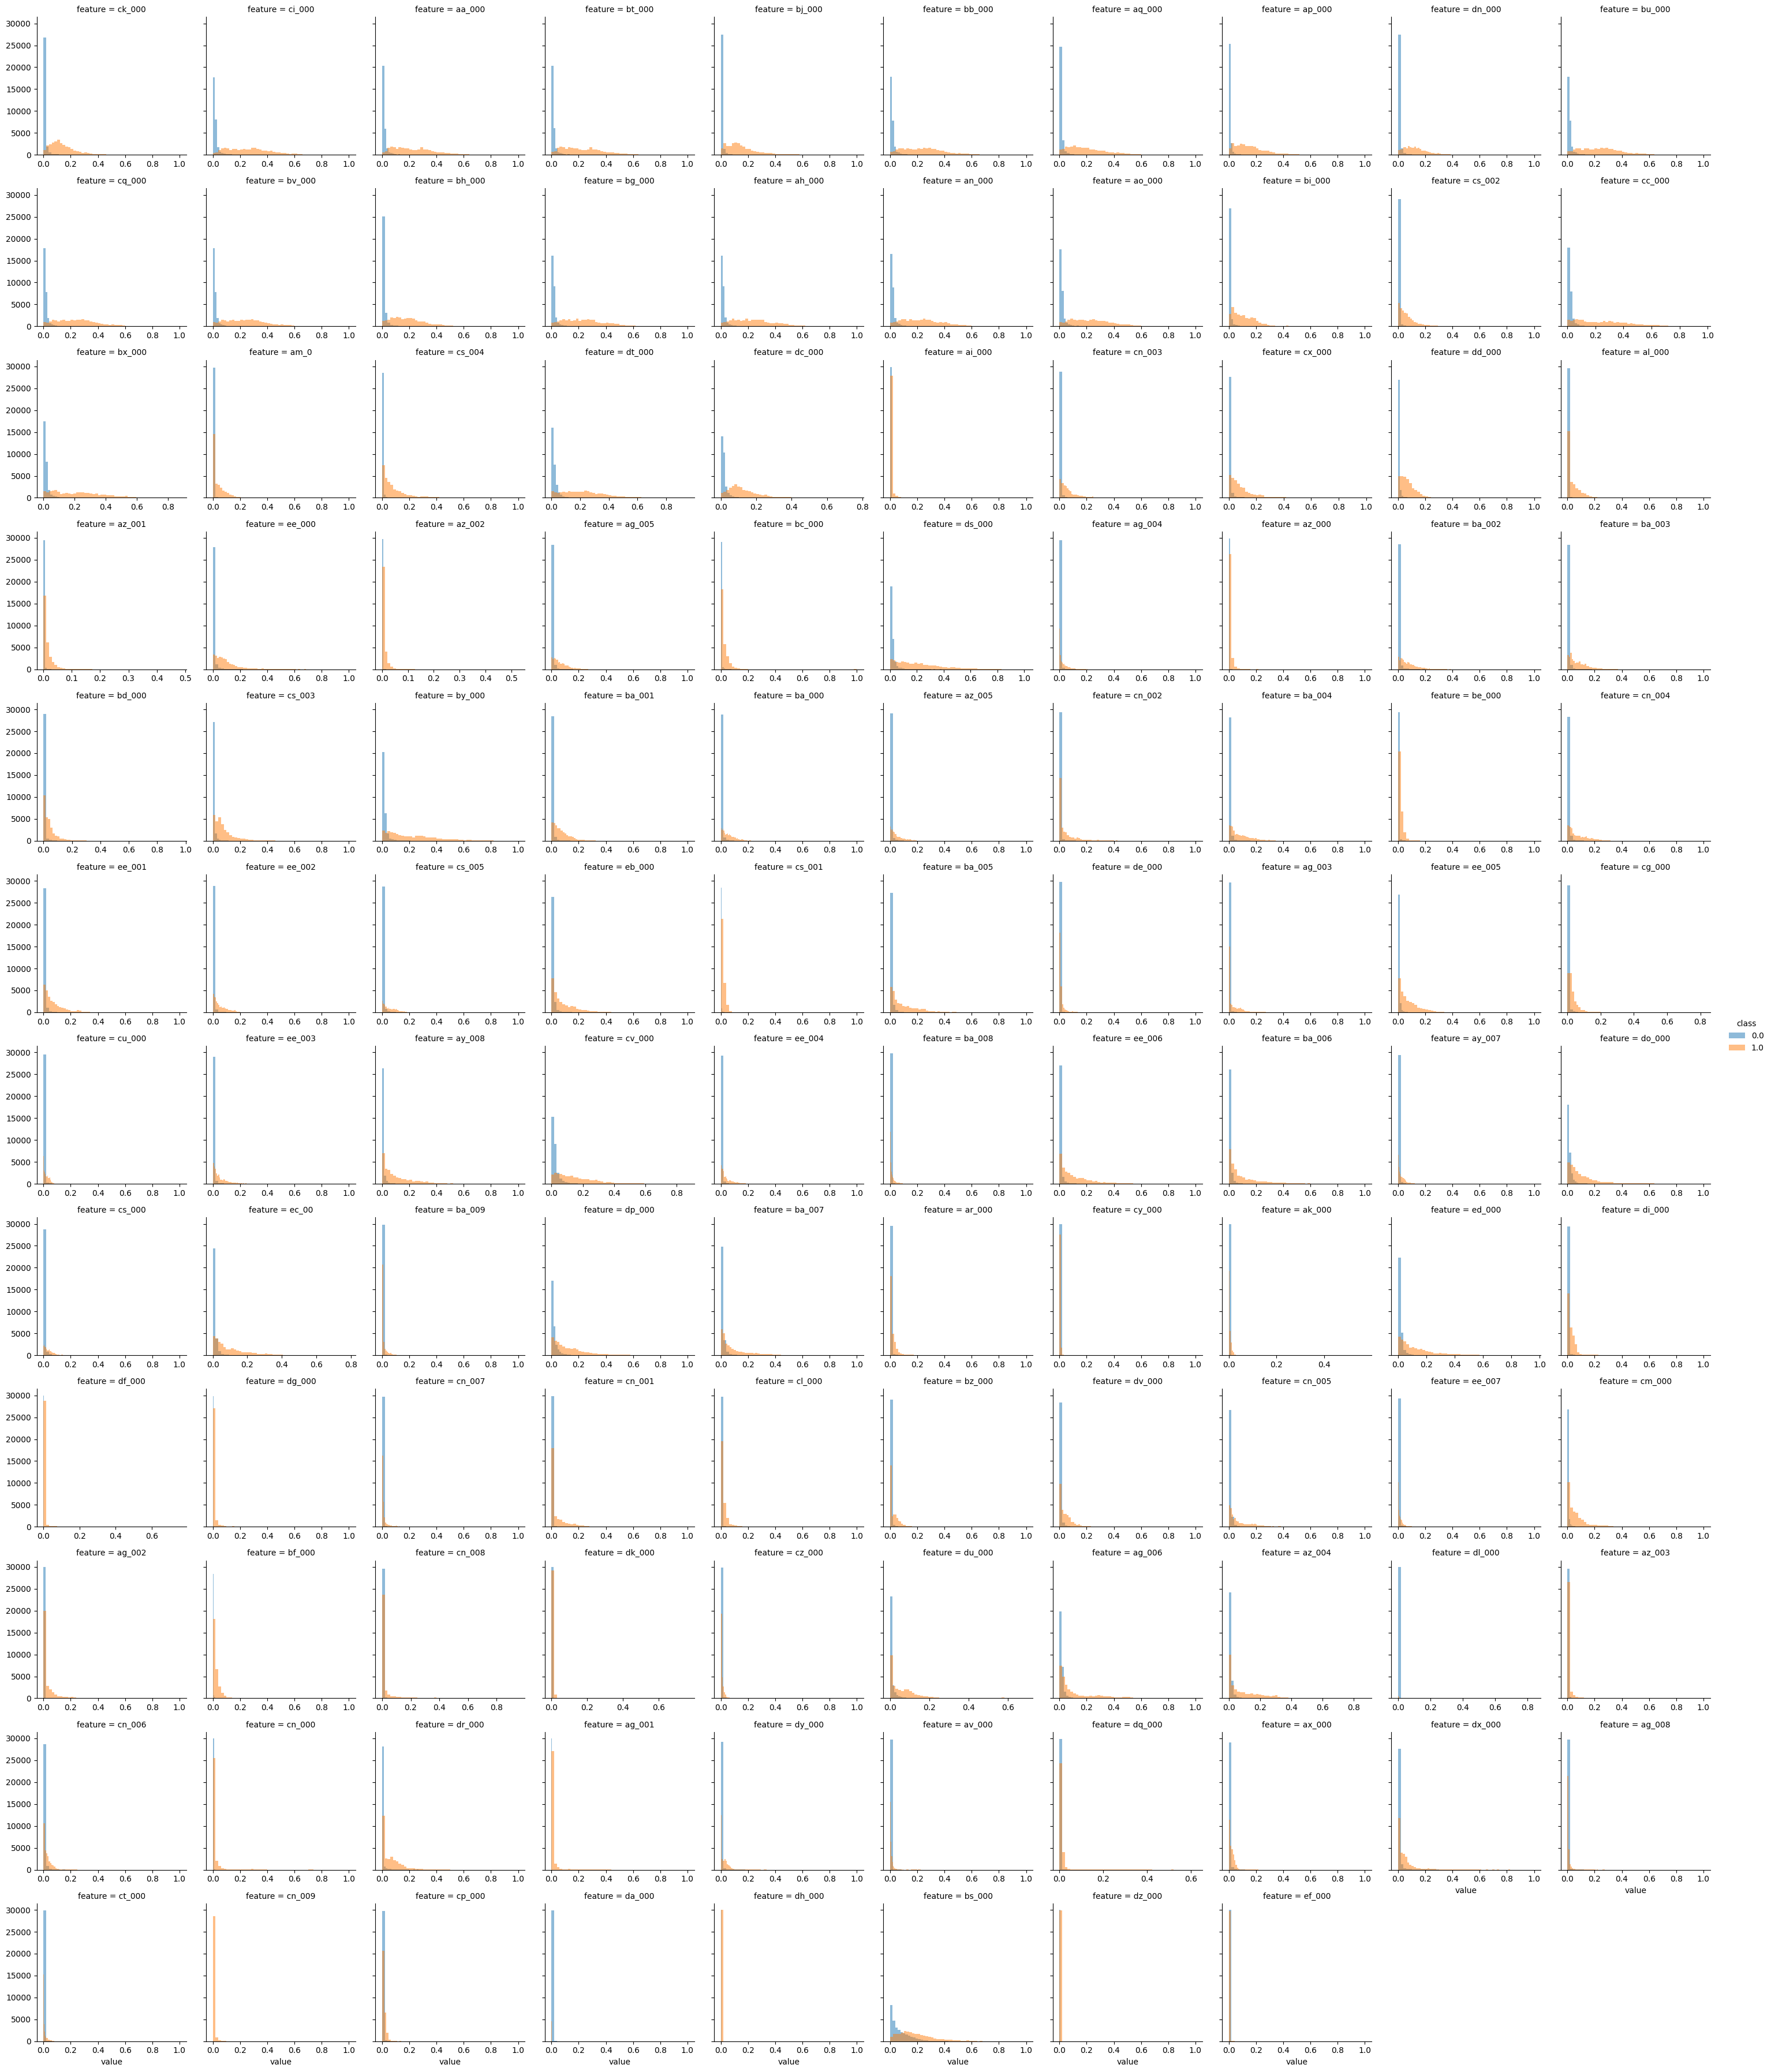

In [48]:
plot_histogram_grid(df_prev_balanced[high_corr_cols.values], col_wrap=10)

In [49]:
models_highcorr = base_models.copy()

train_x_highcorr = df_prev_balanced[high_corr_cols].drop(axis="columns", columns=["class"],inplace=False)
train_x_highcorr.head()

,ck_000,ci_000,aa_000,bt_000,bj_000,bb_000,aq_000,ap_000,dn_000,bu_000,cq_000,bv_000,bh_000,bg_000,ah_000,an_000,ao_000,bi_000,cs_002,cc_000,bx_000,am_0,cs_004,dt_000,dc_000,ai_000,cn_003,cx_000,dd_000,al_000,az_001,ee_000,az_002,ag_005,bc_000,ds_000,ag_004,az_000,ba_002,ba_003,bd_000,cs_003,by_000,ba_001,ba_000,az_005,cn_002,ba_004,be_000,cn_004,ee_001,ee_002,cs_005,eb_000,cs_001,ba_005,de_000,ag_003,ee_005,cg_000,cu_000,ee_003,ay_008,cv_000,ee_004,ba_008,ee_006,ba_006,ay_007,do_000,cs_000,ec_00,ba_009,dp_000,ba_007,ar_000,cy_000,ak_000,ed_000,di_000,df_000,dg_000,cn_007,cn_001,cl_000,bz_000,dv_000,cn_005,ee_007,cm_000,ag_002,bf_000,cn_008,dk_000,cz_000,du_000,ag_006,az_004,dl_000,az_003,cn_006,cn_000,dr_000,ag_001,dy_000,av_000,dq_000,ax_000,dx_000,ag_008,ct_000,cn_009,cp_000,da_000,dh_000,bs_000,dz_000,ef_000
0,0.010779,0.013201,0.012173,0.012173,0.007492,0.014686,0.010563,0.008955,0.008355,0.014686,0.014686,0.014686,0.013746,0.016228,0.016228,0.015152,0.014942,0.007878,0.002098,0.016564,0.015114,0.000000,0.002757,0.023131,0.018465,0.000000,0.002470,0.005509,0.002341,0.000000,0.000341,0.008181,0.000294,0.004181,0.000695,0.013486,2.852766e-05,0.000287,0.002771,0.003053,0.000875,0.003309,0.014092,0.002622,0.005460,0.004013,0.000000,0.003508,0.003092,0.007379,0.004170,0.003092,0.004794,0.024526,0.000670,0.004503,0.000329,0.000000,0.003929,0.003201,0.001387,0.002839,0.004576,0.018611,0.002258,1.504127e-03,9.738098e-03,0.007889,0.001785,0.018782,0.003217,0.008947,0.000015,0.018488,0.017163,0.0,0.000281,0.0,0.017380,0.000000e+00,0.0,0.0,2.277957e-04,0.0,0.001768,0.002026,0.003023,0.007555,0.001284,0.002076,0.0,0.001214,0.000184,0.0,0.000131,0.005114,0.015649,4.631885e-03,0.0,1.199099e-04,1.034595e-03,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0000,0.0,0.000037,0.000313,1.648425e-07,0.000000,0.000247,0.000000,0.064826,0.0,0.0
1,0.000089,0.000148,0.000133,0.000132,0.000059,0.000200,0.000043,0.000108,0.000070,0.000200,0.000200,0.000200,0.000107,0.000139,0.000139,0.000214,0.000223,0.000127,0.000014,0.000182,0.000233,0.000000,0.000013,0.000174,0.010176,0.000000,0.000209,0.002684,0.000162,0.000000,0.000004,0.000087,0.000002,0.000134,0.000000,0.000093,7.254276e-07,0.000127,0.000059,0.000021,0.000150,0.000021,0.000090,0.000069,0.000061,0.000055,0.000000,0.000007,0.000020,0.000040,0.000045,0.000016,0.000016,0.000000,0.000023,0.000006,0.000114,0.000000,0.000249,0.002570,0.000000,0.000007,0.000011,0.014512,0.000004,5.117383e-07,6.327549e-08,0.000010,0.000009,0.000003,0.001489,0.005347,0.000000,0.000006,0.000018,0.0,0.000000,0.0,0.005863,0.000000e+00,0.0,0.0,4.827458e-07,0.0,0.000056,0.000011,0.000028,0.000004,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000076,0.000032,5.363799e-07,0.0,6.581222e-07,6.104294e-07,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0000,0.0,0.000000,0.000000,0.000000e+00,0.000008,0.000189,0.000000,0.007963,0.0,0.0
2,0.024976,0.024995,0.014827,0.014827,0.015311,0.026984,0.024375,0.014434,0.011249,0.026984,0.026984,0.026984,0.027561,0.024394,0.024394,0.028956,0.027639,0.009404,0.008346,0.033506,0.027997,0.000000,0.008183,0.000000,0.028480,0.000000,0.002810,0.004433,0.012818,0.000000,0.000108,0.019856,0.000057,0.003716,0.000071,0.000000,1.879120e-05,0.000260,0.008320,0.007273,0.000111,0.031711,0.017710,0.009638,0.011633,0.006272,0.000000,0.006200,0.000262,0.008690,0.019638,0.005898,0.005684,0.000547,0.002293,0.006482,0.001998,0.000000,0.004254,0.005997,0.003112,0.004137,0.044967,0.030584,0.002793,0.000000e+00,8.222714e-03,0.006400,0.000201,0.000000,0.008567,0.016925,0.000000,0.000000,0.001028,0.0,0.000569,0.0,0.024491,2.957182e-03,0.0,0.0,1.001396e-03,0.0,0.000000,0.000134,0.000000,0.021366,0.001056,0.000000,0.0,0.000000,0.000784,0.0,0.001811,0.000000,0.032315,1.654191e-02,0.0,7.226181e-05,9.433132e-03,0.0,0.0,0.0,0.001718,0.000000,0.0,0.0000,0.0,0.005817,0.003717,1.318740e-06,0.000000,0.000297,0.000011,0.072230,0.0,0.0
3,0.001698,0.003221,0.002659,0.002659,0.001457,0.003241,0.002973,0.002079,0.001713,0.003241,0.003241,0.0032

In [50]:
cv_results_highcorr = cross_validate_models(models_highcorr,train_x_highcorr, train_y,scoring=scorer_multiple)

Cross-validating model: dummy (2023-01-09 22:41:41.082000)


c:\Users\bykiy\anaconda3\envs\ps_bix\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\bykiy\anaconda3\envs\ps_bix\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\bykiy\anaconda3\envs\ps_bix\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\bykiy\anaconda3\envs\ps_bix\lib\site-packages\sklearn\metrics\_classifica

Mean fit_time: 0.034 (0.002)
Mean score_time: 0.053 (0.002)
Mean test_accuracy: 0.500 (0.000)
Mean test_precision: 0.000 (0.000)
Mean test_recall: 0.000 (0.000)
Mean test_f1: 0.000 (0.000)
Mean test_roc_auc_score: 0.500 (0.000)
Mean test_average_precision_score: 0.500 (0.000)
Mean test_maintenance_cost: 3375000.000 (0.000)
time:0:00:00.385937
Cross-validating model: xgb (2023-01-09 22:41:41.467937)
Mean fit_time: 54.604 (3.534)
Mean score_time: 0.712 (0.027)
Mean test_accuracy: 0.995 (0.000)
Mean test_precision: 0.991 (0.000)
Mean test_recall: 0.999 (0.000)
Mean test_f1: 0.995 (0.000)
Mean test_roc_auc_score: 0.995 (0.000)
Mean test_average_precision_score: 0.990 (0.000)
Mean test_maintenance_cost: 230422.500 (956.037)
time:0:03:41.343614
Cross-validating model: lgbm (2023-01-09 22:45:22.811551)
Mean fit_time: 5.715 (0.149)
Mean score_time: 0.772 (0.027)
Mean test_accuracy: 0.994 (0.000)
Mean test_precision: 0.990 (0.000)
Mean test_recall: 0.997 (0.001)
Mean test_f1: 0.994 (0.000)
Mean

### 9. Model comparison

#### Which models seems to have performed best?

1. The **xgb** model, trained using all columns from the dataset (except those columns with more than 50% missing data) scored the best in the most important metrics.

2. The **xgb_highcurr** model, trained using only high correlated features ranked second on the most important metrics.

3. The **lightgbm** model, trained using all columns from the dataset (except those columns with more than 50% missing data) ranked third in the most important metrics.

4. The **xgb_pca** model, trained in a transformed and reduced feature space, scored fourth in the most important metrics.

These best scoring models will be selected for hyperparameter tuning and final evaluation.




In [51]:
def df_from_dict(d):
    return pd.DataFrame.from_dict(d,orient="index").applymap(lambda x: np.mean(x)).sort_values(by="test_maintenance_cost",ascending=True)

In [52]:
df_cv_results = df_from_dict(cv_results)
df_cv_results_pca = df_from_dict(cv_results_pca)
df_cv_results_pca.index = df_cv_results_pca.index + "_pca"
df_cv_results_highcorr = df_from_dict(cv_results_highcorr)
df_cv_results_highcorr.index = df_cv_results_highcorr.index + "_highcorr"
df_cv_results_all = pd.concat([df_cv_results,df_cv_results_pca,df_cv_results_highcorr])
df_cv_results_all.sort_values(by="test_maintenance_cost",ascending=True)

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc_score,test_average_precision_score,test_maintenance_cost
xgb,69.302161,0.946166,0.995533,0.992448,0.998667,0.995547,0.995533,0.991791,230055.00
xgb_highcorr,54.604011,0.712425,0.994800,0.991068,0.998600,0.994820,0.994800,0.990380,230422.50
lgbm,6.030063,0.848449,0.994083,0.990309,0.997933,0.994106,0.994083,0.989295,232608.75
xgb_pca,34.043299,0.492227,0.991483,0.985418,0.997733,0.991537,0.991483,0.984317,233801.25
lgbm_highcorr,5.715222,0.772458,0.993550,0.989812,0.997367,0.993574,0.993550,0.988521,234450.00
rf,31.293155,1.658499,0.992933,0.988957,0.997000,0.992962,0.992933,0.987490,235702.50
rf_highcorr,24.216898,1.390596,0.992233,0.988231,0.996333,0.992265,0.992233,0.986441,237885.00
lgbm_pca,2.499288,0.705615,0.986483,0.978875,0.994433,0.986591,0.986483,0.976208,244950.00
rf_pca,21.137069,1.315211,0.983833,0.973700,0.994533,0.984005,0.983833,0.971110,245242.50
dtc,17.763381,0.186491,0.985383,0.981327,0.989600,0.985445,0.985383,0.976321,259878.75


In [53]:
lowest_maintenance_cost = df_cv_results_all.sort_values(by="test_maintenance_cost",ascending=True).head(4).index[0:4].values
highest_roc_auc = df_cv_results_all.sort_values(by="test_roc_auc_score",ascending=False).head(4).index[0:4].values
highest_average_precision = df_cv_results_all.sort_values(by="test_average_precision_score",ascending=False).head(4).index[0:4].values
highest_precision = df_cv_results_all.sort_values(by="test_precision",ascending=False).head(4).index[0:4].values
highest_recall = df_cv_results_all.sort_values(by="test_recall",ascending=False).head(4).index[0:4].values

print(f'lowest maintenance cost = {lowest_maintenance_cost}')
print(f'highest precision = {highest_precision}')
print(f'highest recall = {highest_recall}')
print(f'highest roc auc = {highest_roc_auc}')
print(f'highest average precision = {highest_average_precision}')

lowest maintenance cost = ['xgb' 'xgb_highcorr' 'lgbm' 'xgb_pca']
highest precision = ['xgb' 'xgb_highcorr' 'lgbm' 'lgbm_highcorr']
highest recall = ['xgb' 'xgb_highcorr' 'lgbm' 'xgb_pca']
highest roc auc = ['xgb' 'xgb_highcorr' 'lgbm' 'lgbm_highcorr']
highest average precision = ['xgb' 'xgb_highcorr' 'lgbm' 'lgbm_highcorr']


### 10. Model tuning

In [54]:
# function to perform grid search
def grid_search(model, param_grid, train_x, train_y, scoring=scorer_multiple, cv=5, refit='maintenance_cost'):
    grid_search = GridSearchCV(model, param_grid, scoring=scoring, cv=cv, refit=refit, verbose=3)
    grid_search.fit(train_x, train_y)
    return grid_search


#### 10.1 Tuning XGBoost model (all features)

In [55]:
#xgb hyperparameter tuning

xgb_param_grid = {
    'max_depth': [3, 6, 10],
    'n_estimators': [50, 100]
}

xgb_grid_search = grid_search(XGBClassifier(), xgb_param_grid, train_x, train_y, scoring=maintenance_cost_scorer, cv=2, refit='maintenance_cost')


Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV 1/2] END max_depth=3, n_estimators=50;, score=-499605.000 total time=  12.8s
[CV 2/2] END max_depth=3, n_estimators=50;, score=-494760.000 total time=  12.8s
[CV 1/2] END max_depth=3, n_estimators=100;, score=-486210.000 total time=  24.8s
[CV 2/2] END max_depth=3, n_estimators=100;, score=-464430.000 total time=  24.6s
[CV 1/2] END max_depth=6, n_estimators=50;, score=-477675.000 total time=  22.1s
[CV 2/2] END max_depth=6, n_estimators=50;, score=-456270.000 total time=  23.4s
[CV 1/2] END max_depth=6, n_estimators=100;, score=-474825.000 total time=  39.6s
[CV 2/2] END max_depth=6, n_estimators=100;, score=-454515.000 total time=  41.0s
[CV 1/2] END max_depth=10, n_estimators=50;, score=-477090.000 total time=  29.3s
[CV 2/2] END max_depth=10, n_estimators=50;, score=-459765.000 total time=  30.6s
[CV 1/2] END max_depth=10, n_estimators=100;, score=-475245.000 total time=  42.9s
[CV 2/2] END max_depth=10, n_estimators=1

#### 10.2 Tuning XGBoost model (only using high correlation features)

In [56]:
#xgb hyperparameter tuning

xgb_highcorr_param_grid = {
    'max_depth': [3, 6, 10],
    'n_estimators': [50, 100]
}

xgb_highcorr_grid_search = grid_search(XGBClassifier(), xgb_highcorr_param_grid, train_x_highcorr, train_y, scoring=maintenance_cost_scorer, cv=2, refit='maintenance_cost')


Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV 1/2] END max_depth=3, n_estimators=50;, score=-535995.000 total time=  10.0s
[CV 2/2] END max_depth=3, n_estimators=50;, score=-522270.000 total time=   9.7s
[CV 1/2] END max_depth=3, n_estimators=100;, score=-491055.000 total time=  20.1s
[CV 2/2] END max_depth=3, n_estimators=100;, score=-477795.000 total time=  21.9s
[CV 1/2] END max_depth=6, n_estimators=50;, score=-476820.000 total time=  18.4s
[CV 2/2] END max_depth=6, n_estimators=50;, score=-466140.000 total time=  19.1s
[CV 1/2] END max_depth=6, n_estimators=100;, score=-474495.000 total time=528.8min
[CV 2/2] END max_depth=6, n_estimators=100;, score=-461985.000 total time=  53.0s
[CV 1/2] END max_depth=10, n_estimators=50;, score=-477165.000 total time=  28.9s
[CV 2/2] END max_depth=10, n_estimators=50;, score=-466665.000 total time=  34.7s
[CV 1/2] END max_depth=10, n_estimators=100;, score=-474390.000 total time=  43.9s
[CV 2/2] END max_depth=10, n_estimators=

#### 10.3 Tuning XGBoost model (PCA)

In [57]:
#xgb_pca hyperparameter tuning

xgb_pca_param_grid = {
    'max_depth': [3, 6, 10],
    'n_estimators': [50, 100]
}
train_x_pca = df_prev_projected.drop(axis="columns", columns=["class"],inplace=False)
xgb_pca_grid_search = grid_search(XGBClassifier(), xgb_pca_param_grid, train_x_pca, train_y, scoring=maintenance_cost_scorer, cv=2, refit='maintenance_cost')


Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV 1/2] END max_depth=3, n_estimators=50;, score=-596175.000 total time=   6.4s
[CV 2/2] END max_depth=3, n_estimators=50;, score=-611880.000 total time=   6.5s
[CV 1/2] END max_depth=3, n_estimators=100;, score=-552525.000 total time=  13.3s
[CV 2/2] END max_depth=3, n_estimators=100;, score=-561150.000 total time=  12.9s
[CV 1/2] END max_depth=6, n_estimators=50;, score=-485085.000 total time=  12.9s
[CV 2/2] END max_depth=6, n_estimators=50;, score=-494715.000 total time=  12.5s
[CV 1/2] END max_depth=6, n_estimators=100;, score=-472260.000 total time=  22.8s
[CV 2/2] END max_depth=6, n_estimators=100;, score=-475440.000 total time=  23.2s
[CV 1/2] END max_depth=10, n_estimators=50;, score=-477360.000 total time=  15.8s
[CV 2/2] END max_depth=10, n_estimators=50;, score=-479700.000 total time=  17.5s
[CV 1/2] END max_depth=10, n_estimators=100;, score=-472470.000 total time=  27.7s
[CV 2/2] END max_depth=10, n_estimators=1

#### 10.4 Tuning LightGBM model (all features)

In [58]:
# lgbm hyperparameter tuning
param_grid = {
    'n_estimators': [50,100],
    'num_leaves': [10, 30],
    'max_depth': [-1, 10, 15],
    # 'reg_alpha': [10, 20],
    # 'reg_lambda': [10, 20] # does it make sense to have regularization parameters in tuning?
}

lgbm_grid_search = grid_search(LGBMClassifier(), param_grid, train_x, train_y, scoring=maintenance_cost_scorer, cv=2, refit='maintenance_cost')


Fitting 2 folds for each of 12 candidates, totalling 24 fits
[CV 1/2] END max_depth=-1, n_estimators=50, num_leaves=10;, score=-568680.000 total time= 1.1min
[CV 2/2] END max_depth=-1, n_estimators=50, num_leaves=10;, score=-539415.000 total time=   1.8s
[CV 1/2] END max_depth=-1, n_estimators=50, num_leaves=30;, score=-497580.000 total time=   2.6s
[CV 2/2] END max_depth=-1, n_estimators=50, num_leaves=30;, score=-484590.000 total time=   2.4s
[CV 1/2] END max_depth=-1, n_estimators=100, num_leaves=10;, score=-503790.000 total time=   3.4s
[CV 2/2] END max_depth=-1, n_estimators=100, num_leaves=10;, score=-484080.000 total time=   3.2s
[CV 1/2] END max_depth=-1, n_estimators=100, num_leaves=30;, score=-480000.000 total time=   4.2s
[CV 2/2] END max_depth=-1, n_estimators=100, num_leaves=30;, score=-458070.000 total time=   5.3s
[CV 1/2] END max_depth=10, n_estimators=50, num_leaves=10;, score=-568680.000 total time=   1.9s
[CV 2/2] END max_depth=10, n_estimators=50, num_leaves=10;, sc

### 11. Training the tuned models on whole training set

#### 11.1 Training XGBoost model on all training data (all features)

In [59]:
print(f'best params = {xgb_grid_search.best_params_}')
print(f'best score = {xgb_grid_search.best_score_}')
xgb_best_params = xgb_grid_search.best_params_
xgb_best_params["alpha"]=20
xgb_best_params["lambda"]=20
xgb_best = XGBClassifier(**xgb_grid_search.best_params_)
xgb_best.fit(train_x, train_y) # train on all data

best params = {'max_depth': 6, 'n_estimators': 100}
best score = -464670.0


XGBClassifier(alpha=20, base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', lambda=20, learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, ...)

#### 11.2 Training XGBoost model on all training data (high correlation features)

In [60]:
print(f'best params = {xgb_highcorr_grid_search.best_params_}')
print(f'best score = {xgb_highcorr_grid_search.best_score_}')
xgb_highcorr_best_params = xgb_highcorr_grid_search.best_params_
xgb_highcorr_best_params["alpha"]=20
xgb_highcorr_best_params["lambda"]=20
xgb_highcorr_best = XGBClassifier(**xgb_highcorr_grid_search.best_params_)
xgb_highcorr_best.fit(train_x_highcorr, train_y) # train on all data

best params = {'max_depth': 6, 'n_estimators': 100}
best score = -468240.0


XGBClassifier(alpha=20, base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', lambda=20, learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, ...)

#### 11.3 Training XGBoost model on all training data (PCA)

In [61]:
print(f'best params = {xgb_pca_grid_search.best_params_}')
print(f'best score = {xgb_pca_grid_search.best_score_}')
xgb_pca_best_params = xgb_pca_grid_search.best_params_
xgb_pca_best_params["alpha"]=20
xgb_pca_best_params["lambda"]=20
xgb_pca_best = XGBClassifier(**xgb_pca_grid_search.best_params_)
xgb_pca_best.fit(train_x_pca, train_y) # train on all data


best params = {'max_depth': 10, 'n_estimators': 100}
best score = -473580.0


XGBClassifier(alpha=20, base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', lambda=20, learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, ...)

#### 11.4 Training lightGBM model on all training data (all features)

In [62]:
print(f'best params = {lgbm_grid_search.best_params_}')
print(f'best score = {lgbm_grid_search.best_score_}')
best_params = lgbm_grid_search.best_params_
best_params["reg_alpha"]=20
best_params["reg_lambda"]=20
lgbm_best = LGBMClassifier(**lgbm_grid_search.best_params_)
lgbm_best.fit(train_x, train_y) # train on all data

best params = {'max_depth': -1, 'n_estimators': 100, 'num_leaves': 30}
best score = -469035.0


LGBMClassifier(num_leaves=30, reg_alpha=20, reg_lambda=20)

### 12. Making predictions over the test set and evaluating the model

#### 12.1 Evaluating XGBoost model (all features)

In [63]:
# final evaluation
test_x = df_curr_processed.drop(axis="columns", columns=["class"],inplace=False)
test_y = df_curr_processed["class"]
results = evaluate_models({'xgb_best':xgb_best}, test_x, test_y)

Evaluating model: xgb_best (2023-01-10 08:02:19.780309)
accuracy=0.988; precision=0.6902286902286903; recall=0.8853333333333333; f1=0.7757009345794392; confusion_matrix=[[15476   149]
 [   43   332]]; tn=15476; fp=149; fn=43; tp=332; costs=31545; specificity=0.990464; sensitivity=0.8853333333333333; false_positive_rate=0.009536; false_negative_rate=0.11466666666666667; roc_auc=0.9378986666666667; pr_auc=0.613769967082467; time:0:00:00.255608


#### 12.2 Evaluating XGBoost model (high correlation features)

In [64]:
# final evaluation
test_x_highcorr = df_curr_processed[high_corr_cols].drop(axis="columns", columns=["class"],inplace=False)
results_xgb = evaluate_models({'xgb_highcorr_best':xgb_highcorr_best}, test_x_highcorr, test_y)

Evaluating model: xgb_highcorr_best (2023-01-10 08:02:20.161526)
accuracy=0.986125; precision=0.6479690522243714; recall=0.8933333333333333; f1=0.7511210762331837; confusion_matrix=[[15443   182]
 [   40   335]]; tn=15443; fp=182; fn=40; tp=335; costs=30780; specificity=0.988352; sensitivity=0.8933333333333333; false_positive_rate=0.011648; false_negative_rate=0.10666666666666667; roc_auc=0.9408426666666666; pr_auc=0.5813523533204383; time:0:00:00.193223


#### 12.3 Evaluating XGBoost model (PCA)

In [65]:
# final evaluation
test_x_pca = df_curr_projected
results_xgb_pca = evaluate_models({'xgb_pca_best':xgb_pca_best}, test_x_pca, test_y)


Evaluating model: xgb_pca_best (2023-01-10 08:02:20.437538)
accuracy=0.9810625; precision=0.5588235294117647; recall=0.912; f1=0.6930091185410334; confusion_matrix=[[15355   270]
 [   33   342]]; tn=15355; fp=270; fn=33; tp=342; costs=29160; specificity=0.98272; sensitivity=0.912; false_positive_rate=0.01728; false_negative_rate=0.088; roc_auc=0.94736; pr_auc=0.5117095588235294; time:0:00:00.202332


#### 12.4 Evaluating lightGBM model (all features)

In [66]:
# final evaluation
results_lgbm = evaluate_models({'lgbm_best':lgbm_best}, test_x, test_y)

Evaluating model: lgbm_best (2023-01-10 08:02:20.714444)
accuracy=0.9845625; precision=0.6176470588235294; recall=0.896; f1=0.7312295973884658; confusion_matrix=[[15417   208]
 [   39   336]]; tn=15417; fp=208; fn=39; tp=336; costs=30750; specificity=0.986688; sensitivity=0.896; false_positive_rate=0.013312; false_negative_rate=0.104; roc_auc=0.941344; pr_auc=0.5558492647058824; time:0:00:00.226023


In [67]:
#df from result dicts
df_results = pd.DataFrame.from_dict(results)
df_results_xgb = pd.DataFrame.from_dict(results_xgb)
df_results_xgb_pca = pd.DataFrame.from_dict(results_xgb_pca)
df_results_lgbm = pd.DataFrame.from_dict(results_lgbm)

#concat all results
df_results_all = pd.concat([df_results,df_results_xgb,df_results_xgb_pca,df_results_lgbm],axis=1).transpose()
df_results_all.sort_values(by="costs",ascending=True)

,accuracy,confusion_matrix,costs,f1,false_negative_rate,false_positive_rate,fn,fp,pr_auc,precision,recall,roc_auc,sensitivity,specificity,tn,tp
xgb_pca_best,0.981062,"[[15355, 270], [33, 342]]",29160,0.693009,0.088,0.01728,33,270,0.51171,0.558824,0.912,0.94736,0.912,0.98272,15355,342
lgbm_best,0.984563,"[[15417, 208], [39, 336]]",30750,0.73123,0.104,0.013312,39,208,0.555849,0.617647,0.896,0.941344,0.896,0.986688,15417,336
xgb_highcorr_best,0.986125,"[[15443, 182], [40, 335]]",30780,0.751121,0.106667,0.011648,40,182,0.581352,0.647969,0.893333,0.940843,0.893333,0.988352,15443,335
xgb_best,0.988,"[[15476, 149], [43, 332]]",31545,0.775701,0.114667,0.009536,43,149,0.61377,0.690229,0.885333,0.937899,0.885333,0.990464,15476,332


### 13. Feature importances

#### What are the most important features when predicting air-system failure?

Features {'aa_000', 'ai_000', 'az_000', 'bj_000', 'by_000', 'ci_000', 'ck_000'} are listed amongst the 5 most important features by at least one of the three best performing models.

Features {'aa_000', 'bj_000', 'ck_000'} appear in all three models!

['by_000', 'az_000', 'aa_000', 'ck_000', 'bj_000']

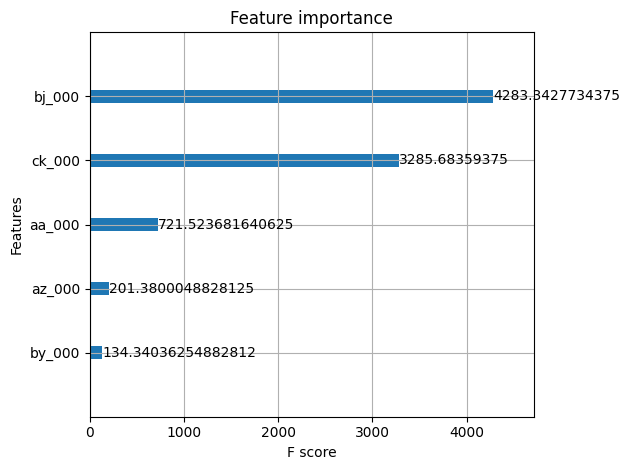

In [68]:
ax1 = plot_importance_xgb(xgb_best,importance_type="gain", max_num_features=5)
top_features_xgb = ax1.get_yticklabels()
top_features_xgb = [x.get_text() for x in top_features_xgb]
top_features_xgb

['by_000', 'az_000', 'aa_000', 'bj_000', 'ck_000']

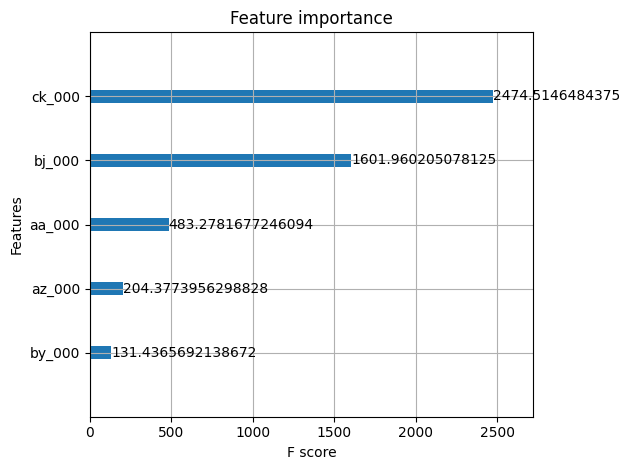

In [69]:
ax2 = plot_importance_xgb(xgb_highcorr_best,importance_type="gain", max_num_features=5)
top_features_xgb_highcorr = ax2.get_yticklabels()
top_features_xgb_highcorr = [x.get_text() for x in top_features_xgb_highcorr]
top_features_xgb_highcorr

['ai_000', 'ci_000', 'aa_000', 'bj_000', 'ck_000']

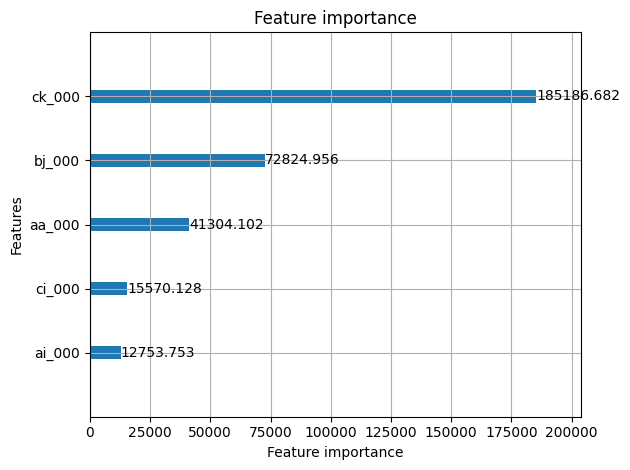

In [70]:
ax3 = plot_importance_lgbm(lgbm_best,importance_type="gain" ,max_num_features=5)
top_features_lgbm = ax3.get_yticklabels()
top_features_lgbm = [x.get_text() for x in top_features_lgbm]
top_features_lgbm

In [71]:
most_important_union = set(top_features_xgb).union(set(top_features_xgb_highcorr)).union(set(top_features_lgbm))
most_important_union

{'aa_000', 'ai_000', 'az_000', 'bj_000', 'by_000', 'ci_000', 'ck_000'}

In [72]:
most_important_intersection = set(top_features_xgb).intersection(set(top_features_xgb_highcorr)).intersection(set(top_features_lgbm))
most_important_intersection

{'aa_000', 'bj_000', 'ck_000'}

#### 13.1 Feature Importance according to XGBoost PCA

['17', '3', '47', '4', '0']

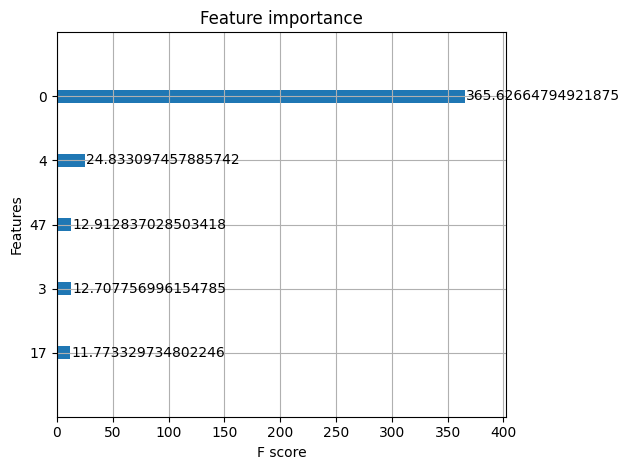

In [73]:
ax4 = plot_importance_xgb(xgb_pca_best,importance_type="gain" ,max_num_features=5)
top_features_xgb_pca = ax4.get_yticklabels()
top_features_xgb_pca = [x.get_text() for x in top_features_xgb_pca]
top_features_xgb_pca

Below, we can have an idea of the composition of each of the most important PCA features 

In [74]:
# find pca components composition for each feature
pca_components = pd.DataFrame(pca.components_, columns=df_curr_processed.drop("class",axis=1).columns)
for i in range(len(pca_components)):
    if str(i) in top_features_xgb_pca:
        print(f'PCA component {i}')
        # select row by index
        row = pca_components.iloc[i]
        # make all values absolute
        row = row.abs()
        print(row.transpose().sort_values(ascending=False).head(5))


PCA component 0
ca_000    0.295757
cc_000    0.211636
ci_000    0.196057
bv_000    0.187156
cq_000    0.187156
Name: 0, dtype: float64
PCA component 3
ac_000    0.724811
ca_000    0.279170
cb_000    0.251191
ag_006    0.145426
dp_000    0.122592
Name: 3, dtype: float64
PCA component 4
ay_008    0.295650
cx_000    0.206777
ee_006    0.200218
cv_000    0.194712
cb_000    0.193355
Name: 4, dtype: float64
PCA component 17
bs_000    0.443984
bl_000    0.397424
bk_000    0.349909
az_004    0.192759
cx_000    0.185342
Name: 17, dtype: float64
PCA component 47
ee_005    0.314541
dr_000    0.301988
az_003    0.298843
dx_000    0.286820
ck_000    0.230202
Name: 47, dtype: float64


In [75]:
pca_components

,aa_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,ay_007,ay_008,ay_009,az_000,az_001,az_002,az_003,az_004,az_005,az_006,az_007,az_008,az_009,ba_000,ba_001,ba_002,ba_003,ba_004,ba_005,ba_006,ba_007,ba_008,ba_009,bb_000,bc_000,bd_000,be_000,bf_000,bg_000,bh_000,bi_000,bj_000,bk_000,bl_000,bs_000,bt_000,bu_000,bv_000,bx_000,by_000,bz_000,ca_000,cb_000,cc_000,cd_000,ce_000,cf_000,cg_000,ch_000,ci_000,cj_000,ck_000,cl_000,cm_000,cn_000,cn_001,cn_002,cn_003,cn_004,cn_005,cn_006,cn_007,cn_008,cn_009,co_000,cp_000,cq_000,cs_000,cs_001,cs_002,cs_003,cs_004,cs_005,cs_006,cs_007,cs_008,cs_009,ct_000,cu_000,cv_000,cx_000,cy_000,cz_000,da_000,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,0.172343,-0.074552,-1.725558e-05,0.000853,0.001353,0.000315,0.007798,0.027383,0.031260,0.022829,0.052234,0.114658,0.042674,0.008157,0.002618,0.175190,0.006498,0.001588,0.004391,0.029777,0.029806,0.178453,0.177596,0.124716,0.159363,0.012165,0.000764,0.004222,0.000920,0.005910,0.014534,0.006122,0.003187,0.013680,0.014113,0.010593,0.018864,0.049631,0.022534,0.088500,0.000449,0.008645,0.012163,0.007022,0.010245,0.082794,0.041067,0.004739,0.003989,0.001523,0.000079,0.044833,0.059392,0.061999,0.064960,0.072493,0.087668,0.100549,0.085250,0.011586,0.008722,0.187034,0.017800,0.032811,0.014011,0.019313,0.175094,0.144339,0.088433,0.125262,0.040714,0.020038,0.072418,0.172802,0.186029,0.187156,0.178527,0.185805,0.034292,0.295757,0.119958,0.211636,0.0,0.034220,-1.726536e-05,0.018518,0.000652,0.196057,0.029228,0.098360,0.028267,0.050347,0.008172,0.037195,0.041943,0.062643,0.065383,0.070347,0.021486,0.010195,0.017526,0.004682,-1.722226e-05,0.010966,0.187156,0.027538,0.012518,0.061320,0.063816,0.083645,0.045567,0.019884,0.001781,6.212099e-07,0.000016,0.009342,0.019225,0.105044,0.074889,0.003991,0.007255,0.000599,0.002769,0.086975,0.052736,0.006857,0.001063,0.005414,0.001325,0.023883,-0.000003,0.003523,0.001070,0.006918,0.097754,0.095174,0.116841,0.009589,0.048060,0.171219,0.171107,0.056153,0.046077,0.036130,0.022754,0.000780,0.000207,0.077628,0.082627,0.108959,0.083519,0.061360,0.044989,0.043643,0.035819,0.065680,0.096492,0.016297,0.043653,0.010663,0.000724,0.000261
1,-0.062945,0.093110,1.065671e-05,-0.000301,-0.000286,-0.000173,-0.006174,-0.018865,-0.019130,-0.012390,-0.017512,-0.006721,-0.000353,-0.003077,0.000426,-0.056694,-0.002575,-0.000488,-0.001502,-0.020392,-0.020926,-0.056782,-0.055298,-0.057537,-0.060164,-0.004503,-0.000534,0.002998,0.001926,-0.002115,-0.006009,-0.000041,-0.002249,-0.014849,-0.012780,-0.009943,-0.008822,0.002428,-0.006472,-0.028461,0.000391,-0.004354,-0.005686,-0.002981,-0.007077,-0.040042,-0.005454,-0.001638,-0.002171,-0.001460,0.000097,-0.009056,-0.017883,-0.020147,-0.020941,-0.022842,-0.020291,-0.013279,-0.020196,-0.006561,-0.007013,-0.065005,-0.005662,-0.012675,-0.003378,-0.003553,-0.056458,-0.047524,-0.040291,-0.058536,-0.105165,-0.079816,0.161118,-0.063654,-0.068097,-0.066104,-0.054815,-0.047047,0.008063,0.619465,0.685380,-0.063140,0.0,-0.010466,1.062108e-05,-0.006342,-0.000122,-0.072647,-0.021326,-0.043257,-0.012122,-0.031342,-0.006247,-0.023150,-0.023029,-0.025157,-0.014034,-0.008728,-0.004487,-0.004109,-0.009778,-0.001871,1.061546e-05,-0.004531,-0.066104,-0.006629,-0.003779,-0.025967,-0.017103,-0.028157,-0.011161,0.002097,0.000718,6.021397e-05,0.000015,-0.000375,-0.004699,-0.034959,-0.034229,-0.001687,-0.000896,-0.000117,0.000567,-0.025735,-0.013125,-0.000564,0.000344,-0.000089,-0.000560,-0.010897,-0.000002,-0.000582,0.000312,-0.004060,-0.036286,0.021123,0.020115,-0.003462,-0.021160,-0.027473,-0.

In [76]:
# Feature importance using ANOVA
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# feature selection
def select_features(X_train, y_train, X_test):
	# configure to select all features
	fs = SelectKBest(score_func=f_classif, k='all')
	# learn relationship from training data
	fs.fit(X_train, y_train)
	# transform train input data
	X_train_fs = fs.transform(X_train)
	# transform test input data
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs, fs


# feature selection
X_train_fs, X_test_fs, fs = select_features(train_x, train_y, test_x)

# create feature importance dataframe
df_feature_importance = pd.DataFrame()
df_feature_importance["feature"] = train_x.columns
df_feature_importance["importance"] = fs.scores_

c:\Users\bykiy\anaconda3\envs\ps_bix\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [82] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\bykiy\anaconda3\envs\ps_bix\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [77]:
df_feature_importance.sort_values(by="importance", ascending=False).head(5)

,feature,importance
87,ci_000,67007.041752
61,bb_000,64339.473583
66,bg_000,63545.064337
15,ah_000,63277.136193
75,bv_000,62870.094555


<AxesSubplot:xlabel='feature'>

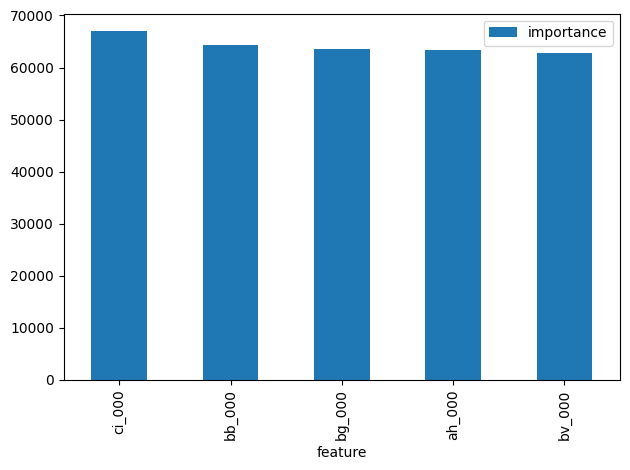

In [78]:
# plot feater importance
df_feature_importance.sort_values(by="importance", ascending=False).head(5).plot.bar(x="feature", y="importance")

### 14. Conclusion

Even seeming to be the fourth best model during cross validation, the XGBoost (PCA) model as tuned scored the best over the test data.